# Universe Machine

# Notes


TODO:
* Once things are restructured get this ready for PR
* https://docs.google.com/document/d/1kRZUw_nHksmnfgu_u6OtERTrl_w-xgio5t7WndmFQPA/edit
* https://redwoodforest.slack.com/archives/D6UA26L6R/p1515102490000636
* Decide how to drop data in the heatmaps
* Sanity check that halo scatter matches stellar scatter (based off the slope): https://redwoodforest.slack.com/archives/C8G02V8F9/p1516236118000202

New TODO:

# Preamble, Imports, Plotting config

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
np.set_printoptions(linewidth=1000)

In [58]:
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import astropy.io.fits
import time
import pandas as pd
import scipy

# My libs
import data
import plots as p
import smhm_fit
import fits
import halo_info


# when we mess up imports
from importlib import reload

In [48]:
mpl.rcParams.update({'figure.dpi': 200})
def fig_font_size(size = 12):
    mpl.rcParams.update({'font.size': size})
fig_font_size()

# Data

In [49]:
# Note that we have already cut (as of 1 Feb) to centrals with mp > 12
# https://github.com/dr-guangtou/hsc_um2/blob/master/scripts/reduce_um_data_size.py
centrals, satellites = data.load()
print(np.log10(np.min(centrals["mp"])))
print(len(centrals))

11.50023647482564
1076948


### Vis raw data

In [ ]:
d = data_stellar_cut["cen"]["data"]
hm_phm_ratio = d["m"] / d["mp"]

fig, ax = plt.subplots()
ax.hist(hm_phm_ratio, bins=50)
ax.set(
    yscale="log",
    ylabel="Count",
    xlabel="HM / Peak HM",
)

In [ ]:
d.dtype

In [ ]:
d  = data_stellar_cut["cen"]["data"], data_stellar_cut["halo"]["data"]
dh = data_stellar_cut["halo"]["data"]["id" == d["id"]]
sm_hm_ratio = (d["sm"] + d["icl"]) / d["m"]
cen_sm_perc = (d["sm"] + d["icl"]) / (dh["sm"] + dh["icl"])

plt.histogram(sm_hm_ratio, cen_sm_perc, bins=50)

In [ ]:
d = data_stellar_cut["cen"]["data"]
sm_hm_ratio = (d["sm"] + d["icl"]) / d["m"]
fig, ax = plt.subplots()
ax.hist(sm_hm_ratio, bins=50)
ax.set(
    ylabel="Count",
    xlabel="SM / HM",
)
ax.axvline(0.2, color="r")

In [ ]:
hm = np.log10(centrals["m"])
sm = np.log10(centrals["sm"] + centrals["icl"])
hist, x_edge, y_edge = np.histogram2d(hm, sm, bins=50)

hist = np.log10(hist)
hist = hist.T

fig, ax = plt.subplots()
img = ax.imshow(hist, origin="lower", extent=[x_edge[0], x_edge[-1], y_edge[0], y_edge[-1]], aspect="auto")
fig.colorbar(img)
ax.set(
    xlabel="HM",
    ylabel="SM",
)
ax.axhline(11.2)
ax.axvline(13)
#ax.axhline(12, c="r")
#ax.axvline(14.5, c="r")

## Process data

### Data with N sats

In [ ]:
data_stellar_cut, data_halo_cut = data.cuts_with_sats(centrals, satellites)

In [57]:
for key in data_stellar_cut.keys():
    mass, csmf = fits.build_csmf(data_stellar_cut, key)
    data_stellar_cut[key]["smf"] = (mass, csmf) # note that these masses are log!

for key in data_halo_cut.keys():
    mass, csmf = fits.build_csmf(data_halo_cut, key)
    data_halo_cut[key]["smf"] = (mass, csmf) # note that these masses are log!
data_stellar_cut
data_stellar_cut["cen"]["hmf"] = fits.build_chmf(data_stellar_cut, "cen")

### Richness data

In [118]:
richness = {
    "richness": data.create_richness_data(centrals, satellites),
}

In [122]:
richness["rmf"] = fits.build_rmf(richness["richness"])
richness["photoz_rmf"] = fits.build_rmf(richness["richness"])

### Sanity checks/exploration

117948
150999
168848


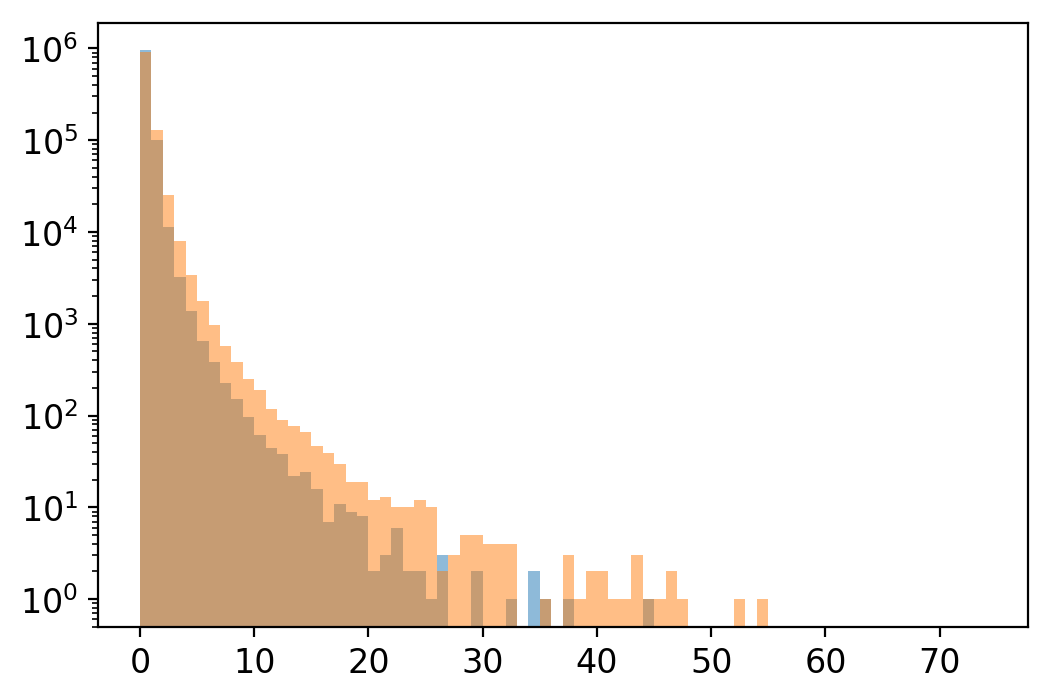

In [163]:
r = richness["richness"]["richness"]
r1 = richness["richness"]["photoz_richness"]

x = plt.hist(r, bins=np.arange(75), alpha=0.5)
x = plt.hist(r1, bins=np.arange(75), alpha=0.5)

plt.yscale('log', nonposy='clip')

print(np.count_nonzero(r >= 1))
print(np.sum(r))
print(np.count_nonzero(r1 >= 1))

In [164]:
print(data_stellar_cut.keys())
for key in data_stellar_cut.keys():
    print(key)
    print(key, len(data_stellar_cut[key]["data"]), len(data_halo_cut[key]["data"]))

dict_keys(['cen', 1, 2, 5, 'halo', 'insitu'])
cen
cen 37477 36491
1
1 39061 36491
2
2 30094 36491
5
5 33983 36491
halo
halo 34869 36491
insitu
insitu 33309 36490


In [165]:
print(data_halo_cut.keys())
print(data_halo_cut["cen"].keys())
print(data_stellar_cut["cen"].keys())
print(len(data_stellar_cut["cen"]["data_cut"]))

dict_keys(['cen', 1, 2, 5, 'halo', 'insitu'])
dict_keys(['data', 'fit', 'data_cut', 'fit_cut', 'mag_gap', 'smf'])
dict_keys(['data', 'fit', 'data_cut', 'fit_cut', 'mag_gap', 'smf', 'hmf'])
37477


### Sanity check these fits

They all kinda look like power laws? A little too much like power laws.

Also some analysis of these fits in the paper

If we are going for a power law, we have
```
log(HM) = log(M1) + B log(SM / sm0)
HM = M1 * (SM/sm0)^B = M1 * SM^B / (sm0)^B = M1/sm0^B * SM^B
log(HM) = log(M1/sm0*B) + B*log(SM)
log(HM) = log(M1)-log(sm0) - log(B) + B*SM
```

In [166]:
print("m1, sm0, beta, delta, gamma")
for key in data_halo_cut.keys():
    f = data_halo_cut[key]["fit"]
    print("{}, {:2f}, {:2f}, {:2f}, {:2f}, {:2f}".format(key, np.log10(f[0]), np.log10(f[1]), f[2], f[3], f[4]))

m1, sm0, beta, delta, gamma
cen, 12.935346, 10.954858, 0.382429, 0.224716, 1.649295
1, 12.883565, 11.130136, 0.779331, 0.156323, 1.026725
2, 14.112270, 11.979857, 1.120076, 0.000000, 0.828510
5, 13.284356, 11.514671, 0.524564, 0.210898, 0.923283
halo, 12.743339, 11.040177, 1.115193, 0.000000, 0.000000
insitu, 14.623166, 10.991189, 5.267735, 0.044830, 1.424472


In [ ]:
def get_power_law_coeffs(m1, sm0, beta, delta, gamma):
    if np.abs(gamma) > 1e-9 or np.abs(delta) > 1e-9:
        print("not a power law!")
        return
    # y = az^(b)
    a = np.log10(m1) - np.log10(sm0) - np.log10(beta)
    b = beta
    print("HM = {} * SM ^ {}".format(a, b))
    print("SM = {} * HM ^ {}".format(1/(a**(1/b)), 1/b))
for key in data_halo_cut.keys():
    print(key)
    get_power_law_coeffs(*data_halo_cut[key]["fit"])
for key in data_stellar_cut.keys():
    print(key)
    get_power_law_coeffs(*data_stellar_cut[key]["fit"])

In [ ]:
for key in data_halo_cut.keys():
    print(data_halo_cut[key]["fit"])

#### Plots

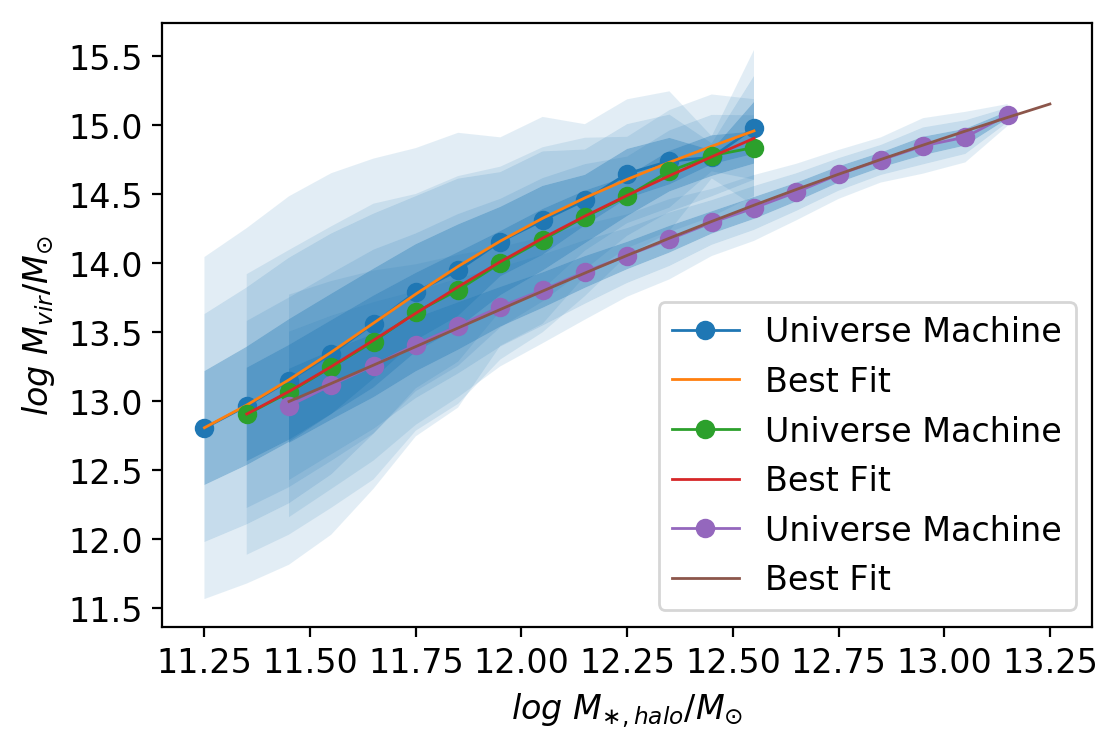

In [59]:
_, ax = plt.subplots()
for key in ["cen", 1, "halo"]: #data_stellar_cut.keys():
    p.sm_hm.hm_at_fixed_sm(data_stellar_cut[key]["data"], key, fit=data_stellar_cut[key]["fit"], ax =ax)

In [ ]:
for key in ["cen"]:#data_halo_cut.keys():
    p.sm_hm.sm_at_fixed_hm(data_halo_cut[key]["data"], key, fit=data_halo_cut[key]["fit"])

# Intro Plot

Intro everything by showing the SM-HM plot + some of the scatter plots (including lit values)

In [169]:
%debug

> /home/christopher/research/hsc_um2/cb/plots/scatter.py(74)in_sm_at_fixed_hm_incl_lit()
     72         v = central_catalogs[cat]
     73         if cat == "insitu": cat = "in" #hack hack hack
---> 74         halo_masses = np.log10(v[data_key]["m"])
     75         stellar_masses = np.log10(v[data_key]["icl"] + v[data_key]["sm"])
     76 

ipdb> k
*** NameError: name 'k' is not defined
ipdb> exit()


[14726, 9279, 5597, 3294, 1822, 974, 469, 203, 92, 27, 6]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]


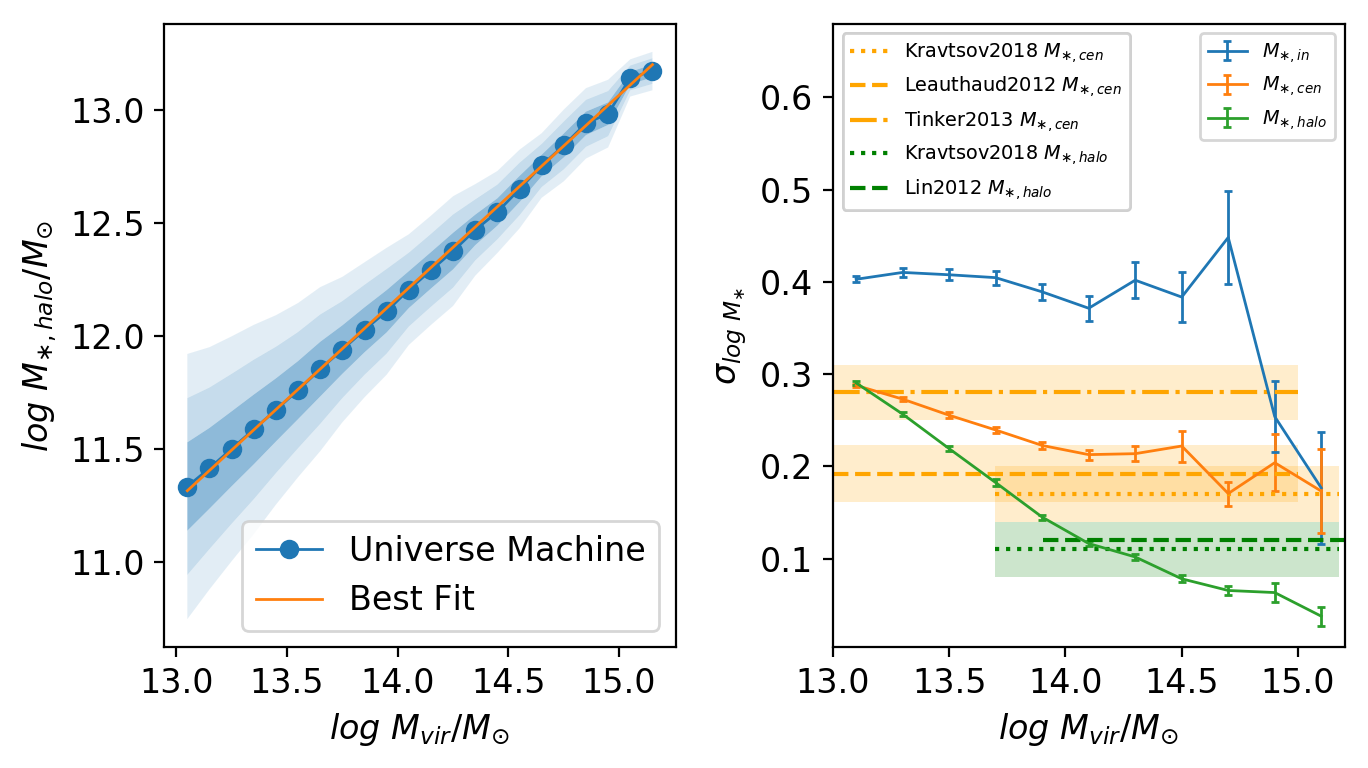

In [177]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(7, 4)
p.sm_hm.sm_at_fixed_hm(data_halo_cut["halo"]["data"], "halo", fit=data_halo_cut["halo"]["fit"], ax=axes[0])
p.scatter.in_sm_at_fixed_hm_incl_lit(data_halo_cut, ax=axes[1])
plt.tight_layout()

# Scatter for various definitions of stellar mass

[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[14726, 9279, 5597, 3294, 1822, 974, 469, 204, 92, 27, 6]
[11, 27, 62, 149, 353, 839, 1996, 4847, 11381]
[10, 27, 62, 150, 359, 833, 2048, 4806, 11415]
[12, 27, 60, 147, 350, 862, 2023, 4768, 11597]
[10, 27, 62, 150, 354, 831, 2053, 4811, 11479]
[10, 27, 63, 149, 359, 852, 2026, 4816, 11558]


(0.0, 0.45719730284055954)

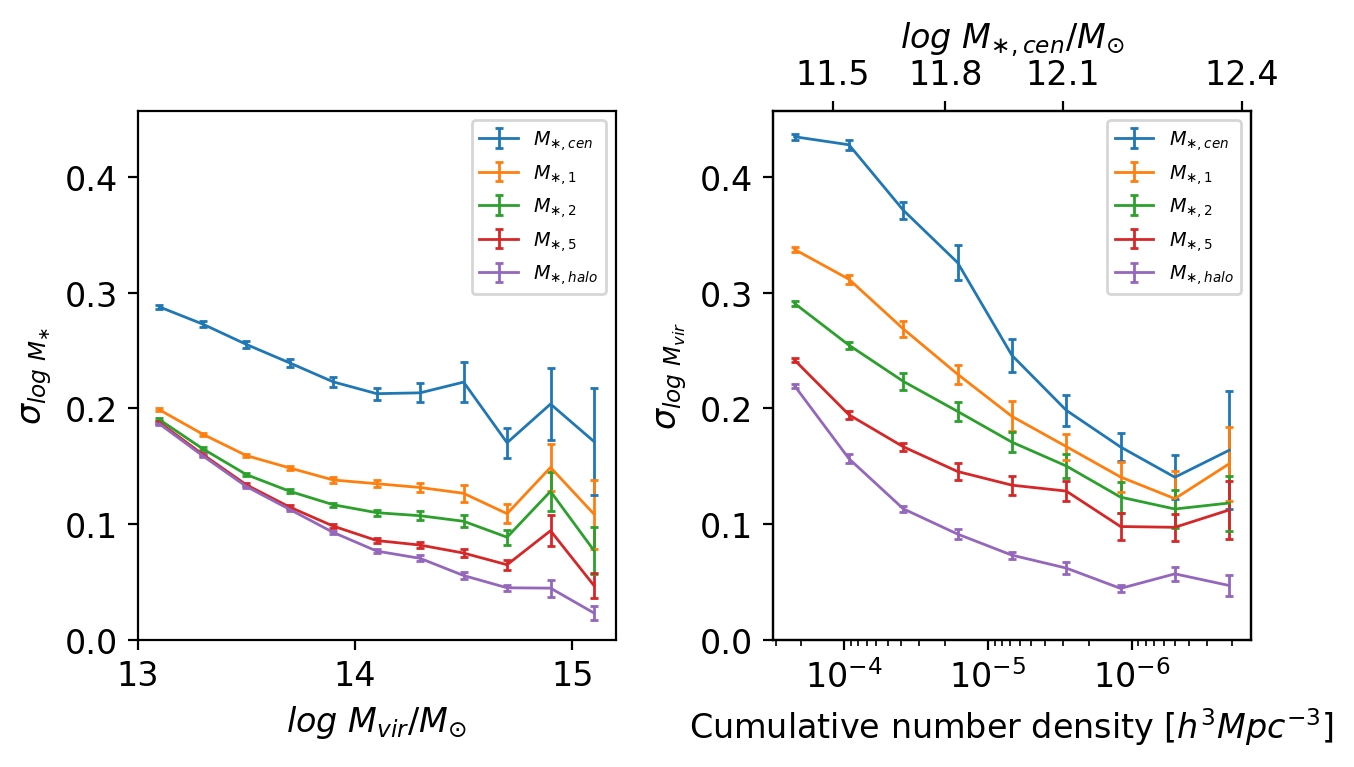

In [181]:
fig, axes = plt.subplots(1, 2)
fig.set_size_inches(7, 4)
p.scatter.in_sm_at_fixed_hm(data_halo_cut, ax=axes[0])
p.scatter.in_hm_at_fixed_number_density(data_stellar_cut, ax=axes[1])
plt.tight_layout()
axes[0].set_ylim(axes[1].get_ylim())

# Stellar mass function for various SMs and vs HSC etc


In [26]:
assert fits.density_at_mass(data_stellar_cut, "cen", fits.mass_at_density(data_stellar_cut, "cen", 1e2)) == 1e2

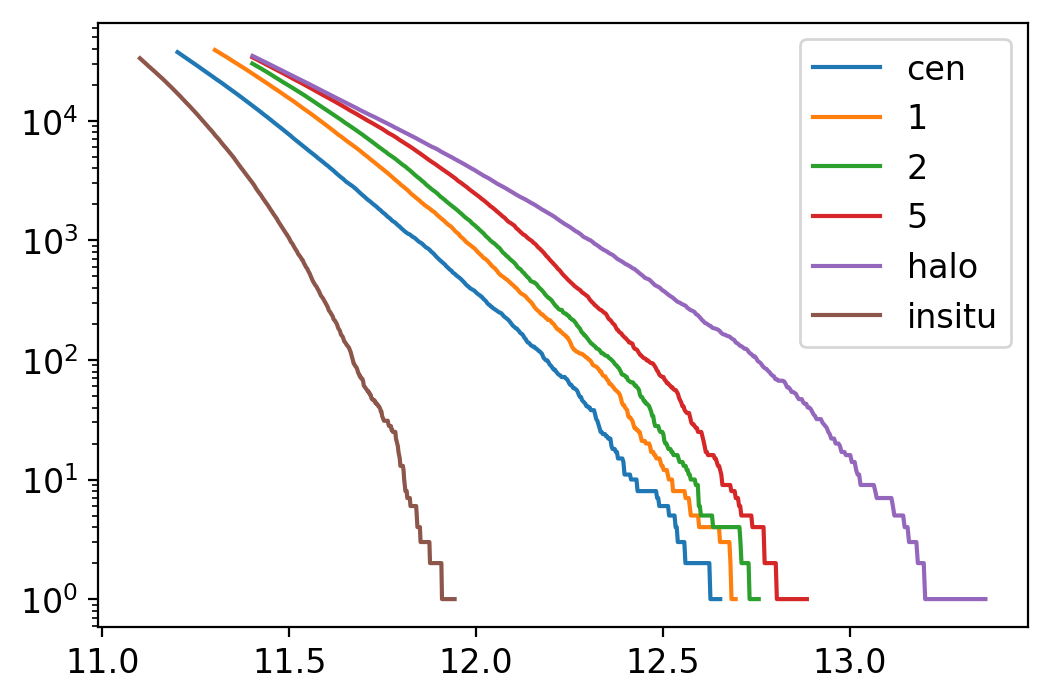

In [27]:
_, ax = plt.subplots()
for key in data_stellar_cut.keys():
    smf_data = data_stellar_cut[key]["smf"]
    ax.plot(smf_data[0], smf_data[1], label=key)
ax.set_yscale("log")
ax.legend()

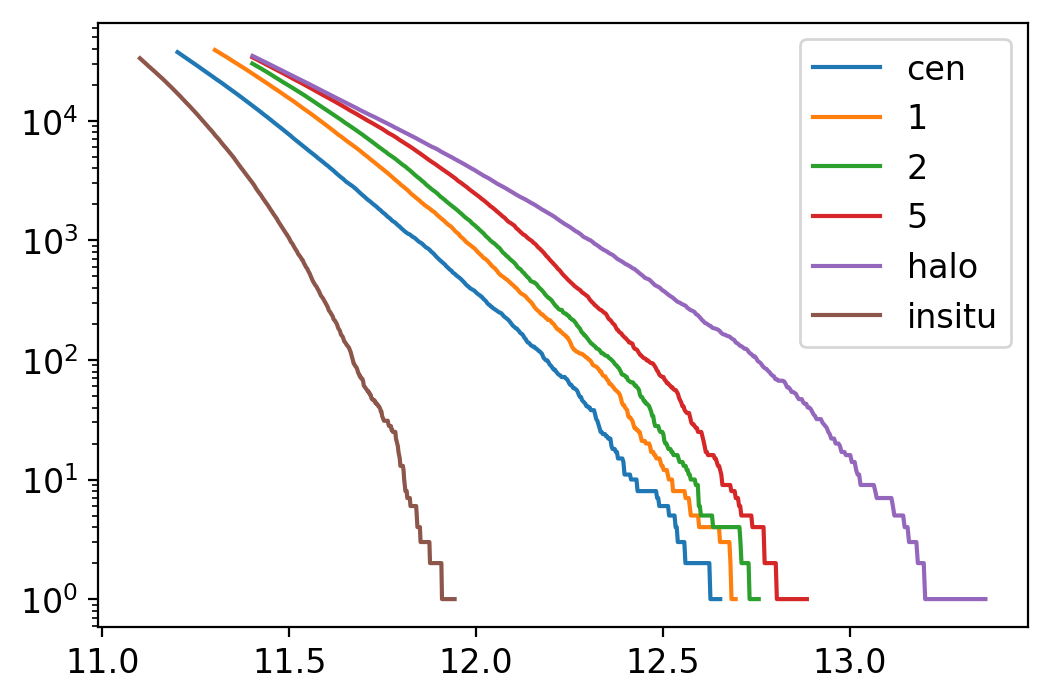

In [28]:
_, ax = plt.subplots()
for key in data_stellar_cut.keys():
    smf_data = data_stellar_cut[key]["smf"]
    ax.plot(smf_data[0], smf_data[1], label=key)
ax.set_yscale("log")
ax.legend()

### Comparison with HSC etc

In [ ]:
hsc_smf_file_m10 = "/home/christopher/research/hsc_um2/data/s16a_massive_fastlane_logm10_smf_default.fits"
hsc_smf_file_m100 = "/home/christopher/research/hsc_um2/data/s16a_massive_fastlane_logm100_smf_default.fits"

m10_smf = astropy.io.fits.open(hsc_smf_file_m10)[1].data
m100_smf = astropy.io.fits.open(hsc_smf_file_m100)[1].data

In [ ]:
print(m10_smf.dtype)
print(m10_smf)

In [ ]:
def plot_sim_smf(stellar_masses, ax, label):

    nonzero_stellar_masses = np.log10(stellar_masses[stellar_masses != 0])
    print("Dropped {} galaxies with mass of 0".format(len(stellar_masses) - len(nonzero_stellar_masses)))

    sim_volume = 400**3 # https://redwoodforest.slack.com/archives/C5W6EQCAU/p1513187949000425 SMDPL
    num_bins = 30
    x, y, err = smf.compute_smf(
        nonzero_stellar_masses, sim_volume, num_bins, 
        np.min(nonzero_stellar_masses), np.max(nonzero_stellar_masses),
    )
    ax.errorbar(x, y, yerr = err, label=label)


fig, ax = plt.subplots()
ax.errorbar(m10_smf["logm_mean"], m10_smf["smf"], yerr = m10_smf["smf_err"], label="HSC m10")
ax.errorbar(m100_smf["logm_mean"], m100_smf["smf"], yerr = m100_smf["smf_err"], label="HSC m100")
plot_sim_smf(centrals["sm"], ax, "universe machine insitu centrals")
plot_sim_smf(centrals["sm"] + centrals["icl"], ax, "all mass cents")
plot_sim_smf(np.append(centrals["sm"] + centrals["icl"], satellites["sm"] + satellites["icl"]), ax, "all mass cents and sats")
ax.legend()
ax.set(
    yscale="log",
    xlim=[11, 12.4],
)
fig.set_size_inches(18.5, 10.5)

# Richness as an estimator

What about richness? Does that have a relation with scatter at fixed halo mass

## Sanity check RMF

In [ ]:
fits.density_at_richness(data_stellar_cut, "cen", fits.richness_at_density(data_stellar_cut, "cen", 2e-4))

In [ ]:
#p.scatter.in_richness_at_fixed_hm(data_halo_cut)
#p.scatter.in_hm_at_fixed_richness_number_density(data_stellar_cut)

_, ax = plt.subplots()
rmf_data = data_stellar_cut["cen"]["rmf"]
ax.plot(rmf_data[0], rmf_data[1], label="stellar cut")
rmf_data = data_halo_cut["cen"]["rmf"]
ax.plot(rmf_data[0], rmf_data[1], label="halo cut")
ax.set_yscale("log")
ax.legend()

(array([ 20.,  62., 177., 429., 740., 832., 546., 192.,  40.,   3.]),
 array([12.65513843, 12.82809577, 13.0010531 , 13.17401043, 13.34696776, 13.51992509, 13.69288242, 13.86583975, 14.03879708, 14.21175441, 14.38471174]),
 <a list of 10 Patch objects>)

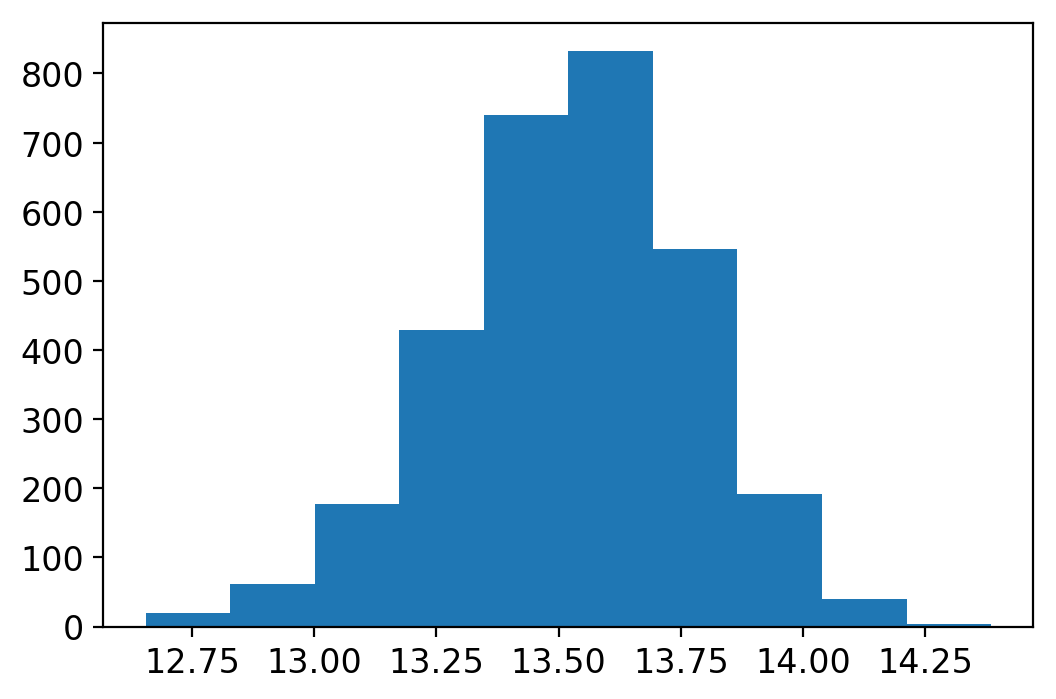

In [38]:
r = data_stellar_cut["cen"]["richness"]

ex = r[r["richness"] == 2]
#plt.hist(r, bins=int(np.max(r["richness"])))
#plt.yscale("log")
plt.hist(np.log10(ex["m"]))

## Richness plots


[11, 27, 62, 149, 353, 839, 1996, 4847, 11381]
[12, 27, 60, 147, 350, 862, 2023, 4768, 11597]
[10, 27, 63, 149, 359, 852, 2026, 4816, 11558]
[11344, 3220, 2024, 606, 247, 144, 62, 35, 13, 6]
[11, 27, 62, 149, 353, 839, 1996, 4847, 11381]
[12, 27, 60, 147, 350, 862, 2023, 4768, 11597]
[10, 27, 63, 149, 359, 852, 2026, 4816, 11558]
[25320, 7880, 5160, 1526, 632, 400, 190, 107, 45, 27]


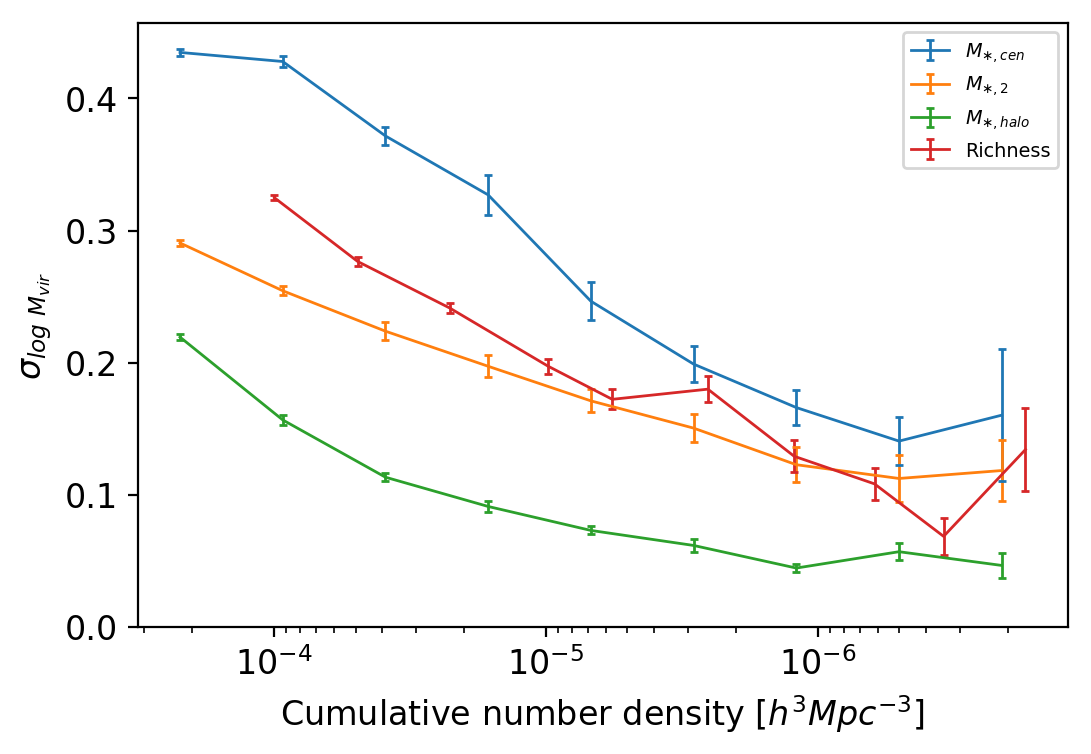

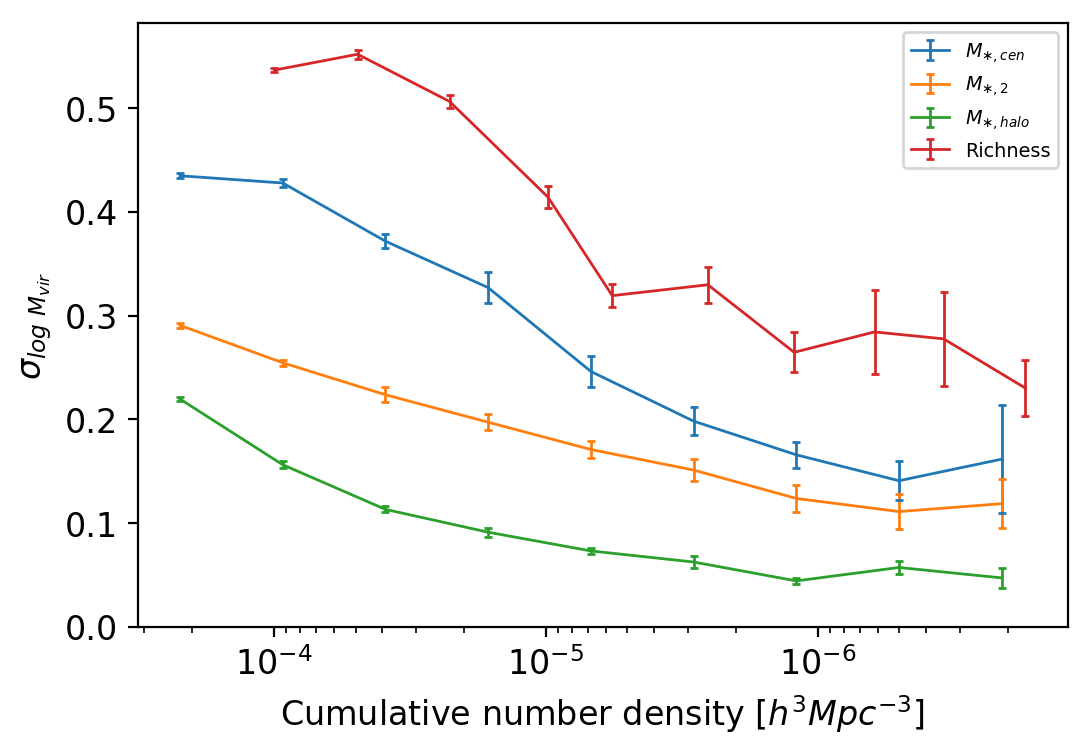

In [180]:
ax = p.scatter.in_hm_at_fixed_number_density_incl_richness(data_stellar_cut, richness)
ax = p.scatter.in_hm_at_fixed_number_density_incl_richness(data_stellar_cut, richness, is_photoz=True)

In [143]:
richness.keys()

dict_keys(['richness', 'rmf', 'photoz_rmf'])

[ 2.5  3.5  5.   7.   9.  11.5 14.5 18.  22.  26.  33.5]
[11344, 3220, 2024, 606, 247, 144, 62, 35, 13, 6, 7]


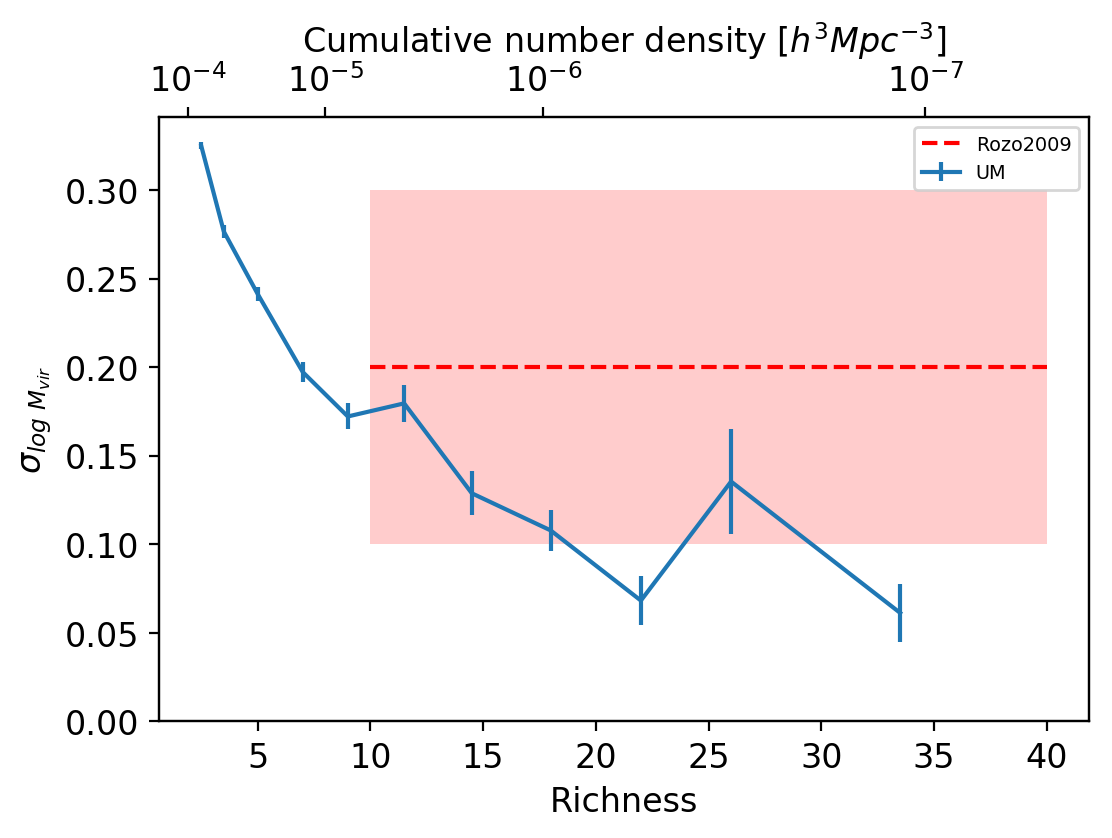

In [162]:
ax = p.scatter.in_hm_at_fixed_richness_number_density(richness)

### Old color plots

In [ ]:
# Only count sats of a large enough size towards richness
minMassForRichness = 10**10.8
richness = cluster_sum.get_richness(centrals_halo_cut, satellites, minMassForRichness)
print("Out of {} clusters, {} have a richness > 0".format(len(richness), np.count_nonzero(richness)))
heatmaps.richness_and_hm_vs_sm_scatter(
    data_halo_cut[0]["data"],
    satellites,
    minMassForRichness,
    data_halo_cut[0]["fit"],
    0,
)

In [ ]:
heatmaps.richness_and_sm_vs_hm_scatter(
    data_stellar_cut[0]["data"],
    satellites,
    minMassForRichness,
    data_stellar_cut[0]["fit"],
    0,
)

# Is cen scatter correlated with halo scatter?

In [ ]:
cens_bias = halo_info.get_sm_bias(data_halo_cut["cen"], include_id=True)
halos_bias = halo_info.get_sm_bias(data_halo_cut["halo"], include_id=True)

In [ ]:
cen_bias = pd.DataFrame({"cen_bias": cens_bias["sm_bias"]}, index=cens_bias["id"])
halo_bias = pd.DataFrame({"halo_bias": halos_bias["sm_bias"]}, index=halos_bias["id"])

In [ ]:
print(cen_bias.head())
print(halo_bias.head())

In [ ]:
joined = cen_bias.join(halo_bias, how="inner")

In [ ]:
fig, ax = plt.subplots()
_, _, _, img = ax.hist2d(joined["cen_bias"], joined["halo_bias"], cmap="OrRd", norm=mpl.colors.LogNorm(), bins=30)
ax.set(xlabel=r"$M_{\ast, cen}\ scatter$", ylabel=r"$M_{\ast, halo}\ scatter$")
plt.colorbar(img, label="count")

In [168]:
# Exp
z = data.unify(data_halo_cut, "cen", "halo")

In [173]:
z.head()
print(len(z))
print(len(data_halo_cut["cen"]["data"]))
print(len(data_halo_cut[1]["data"]))

36491
36491
36491


# What could cause the scatter in the SMHR?

## Lasso to find the best linear model

Using log10(alpha) of -3.5
[ 0.          0.24721144 -0.03445186  0.01277936 -0.42243104] 0.15241898176225052


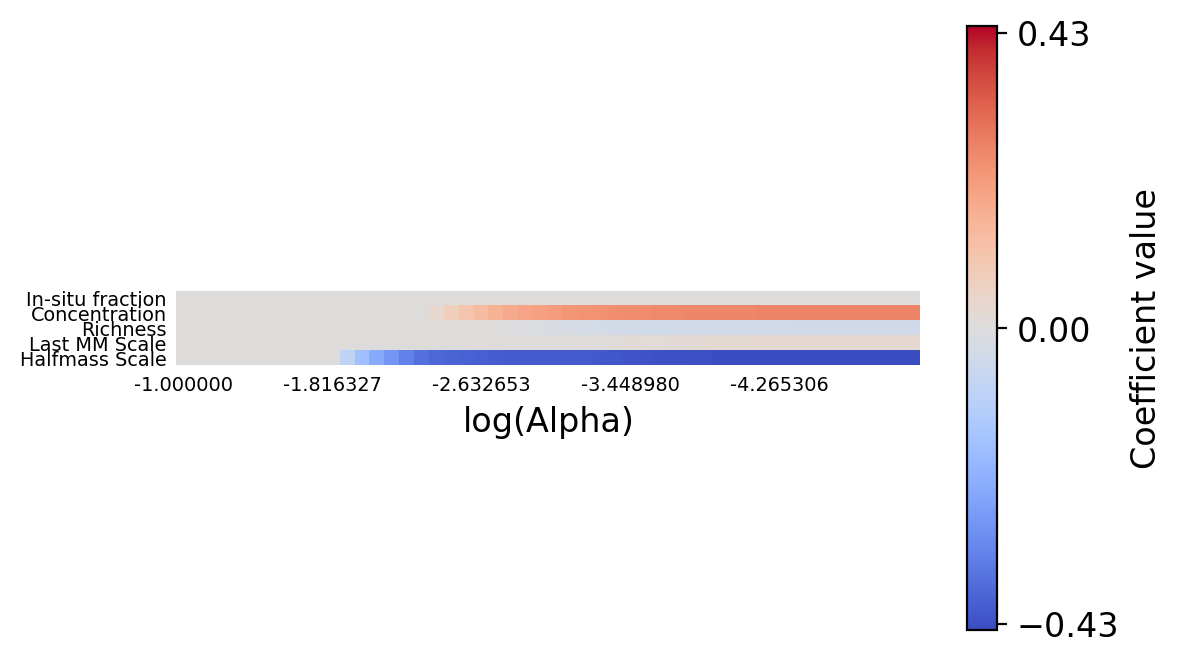

In [323]:
weights, intercept = p.physical_correlation_plots.lasso(data_halo_cut["cen"])
print(weights, intercept)

Using log10(alpha) of -3.5


(array([ 0.1758792 , -0.        ,  0.22957802,  0.11525692, -0.10350068]),
 -0.15263275335489765)

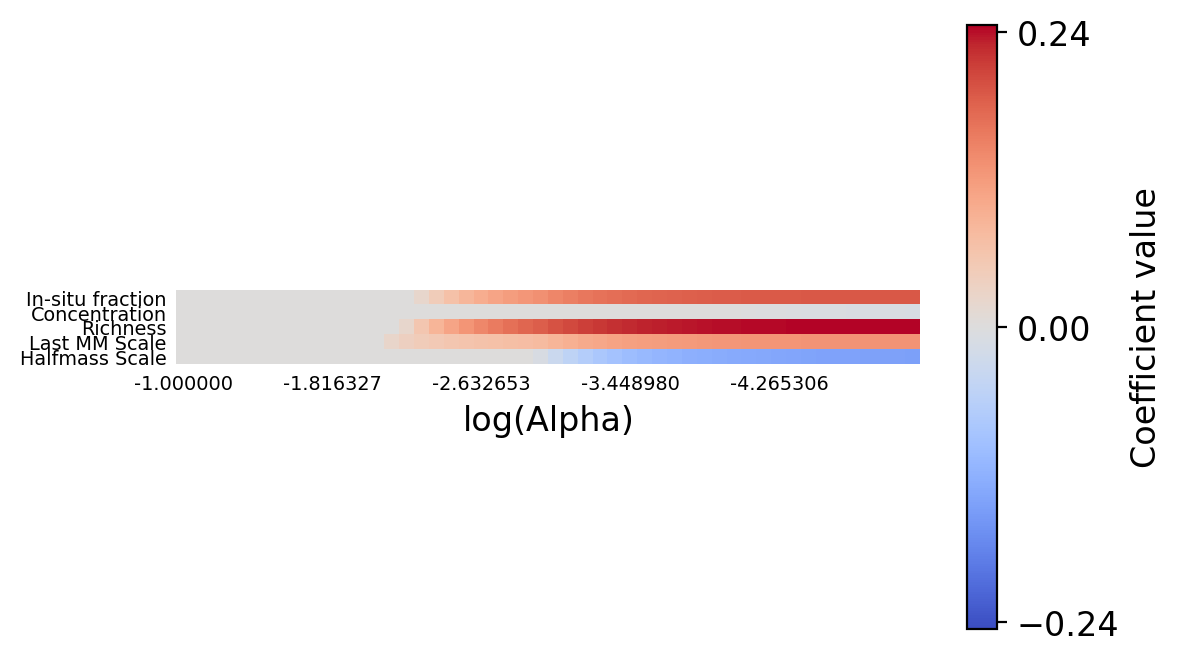

In [324]:
p.physical_correlation_plots.lasso(data_halo_cut["halo"])

## Correlation plots

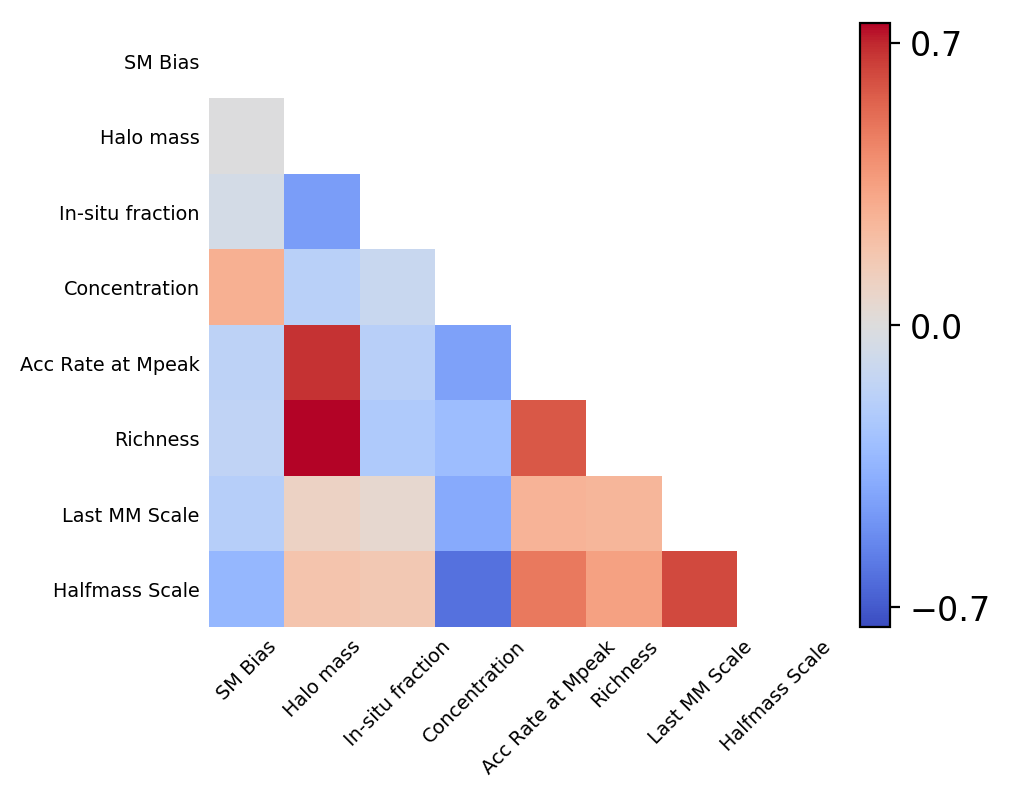

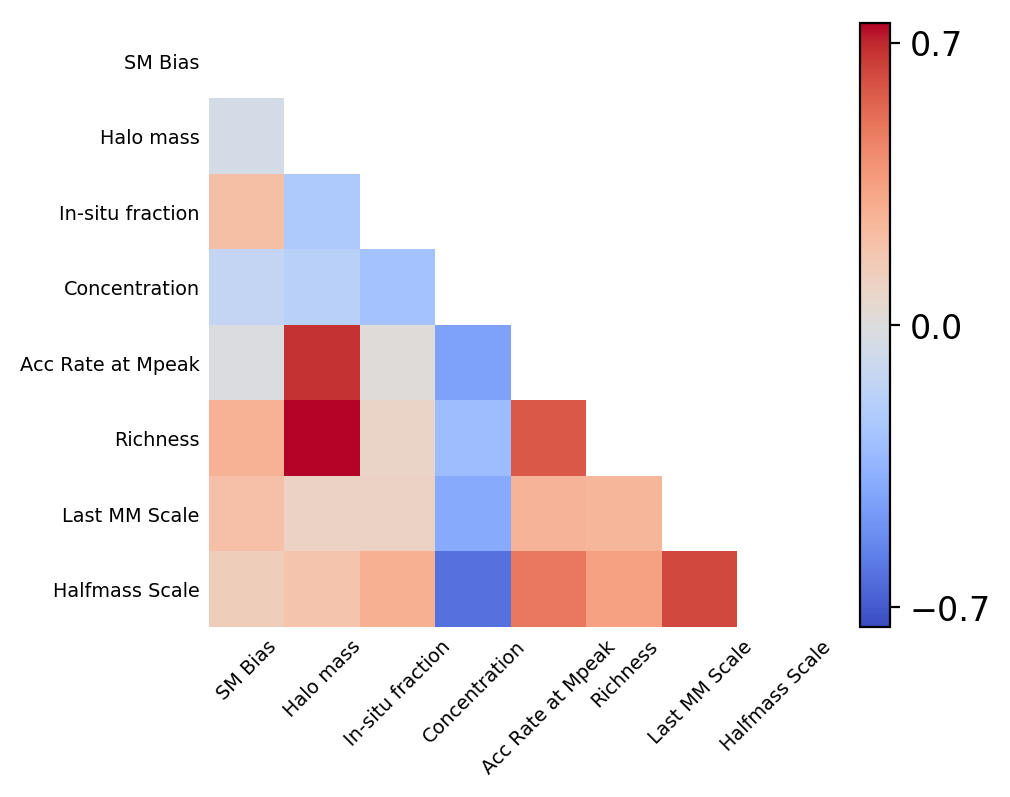

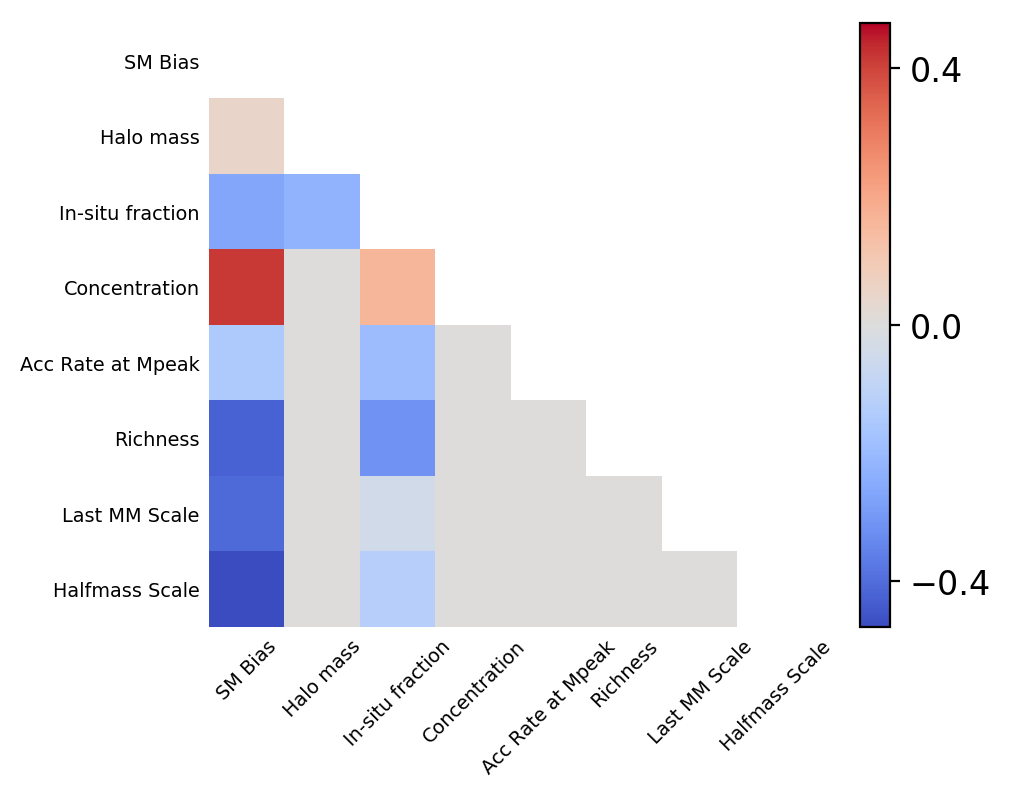

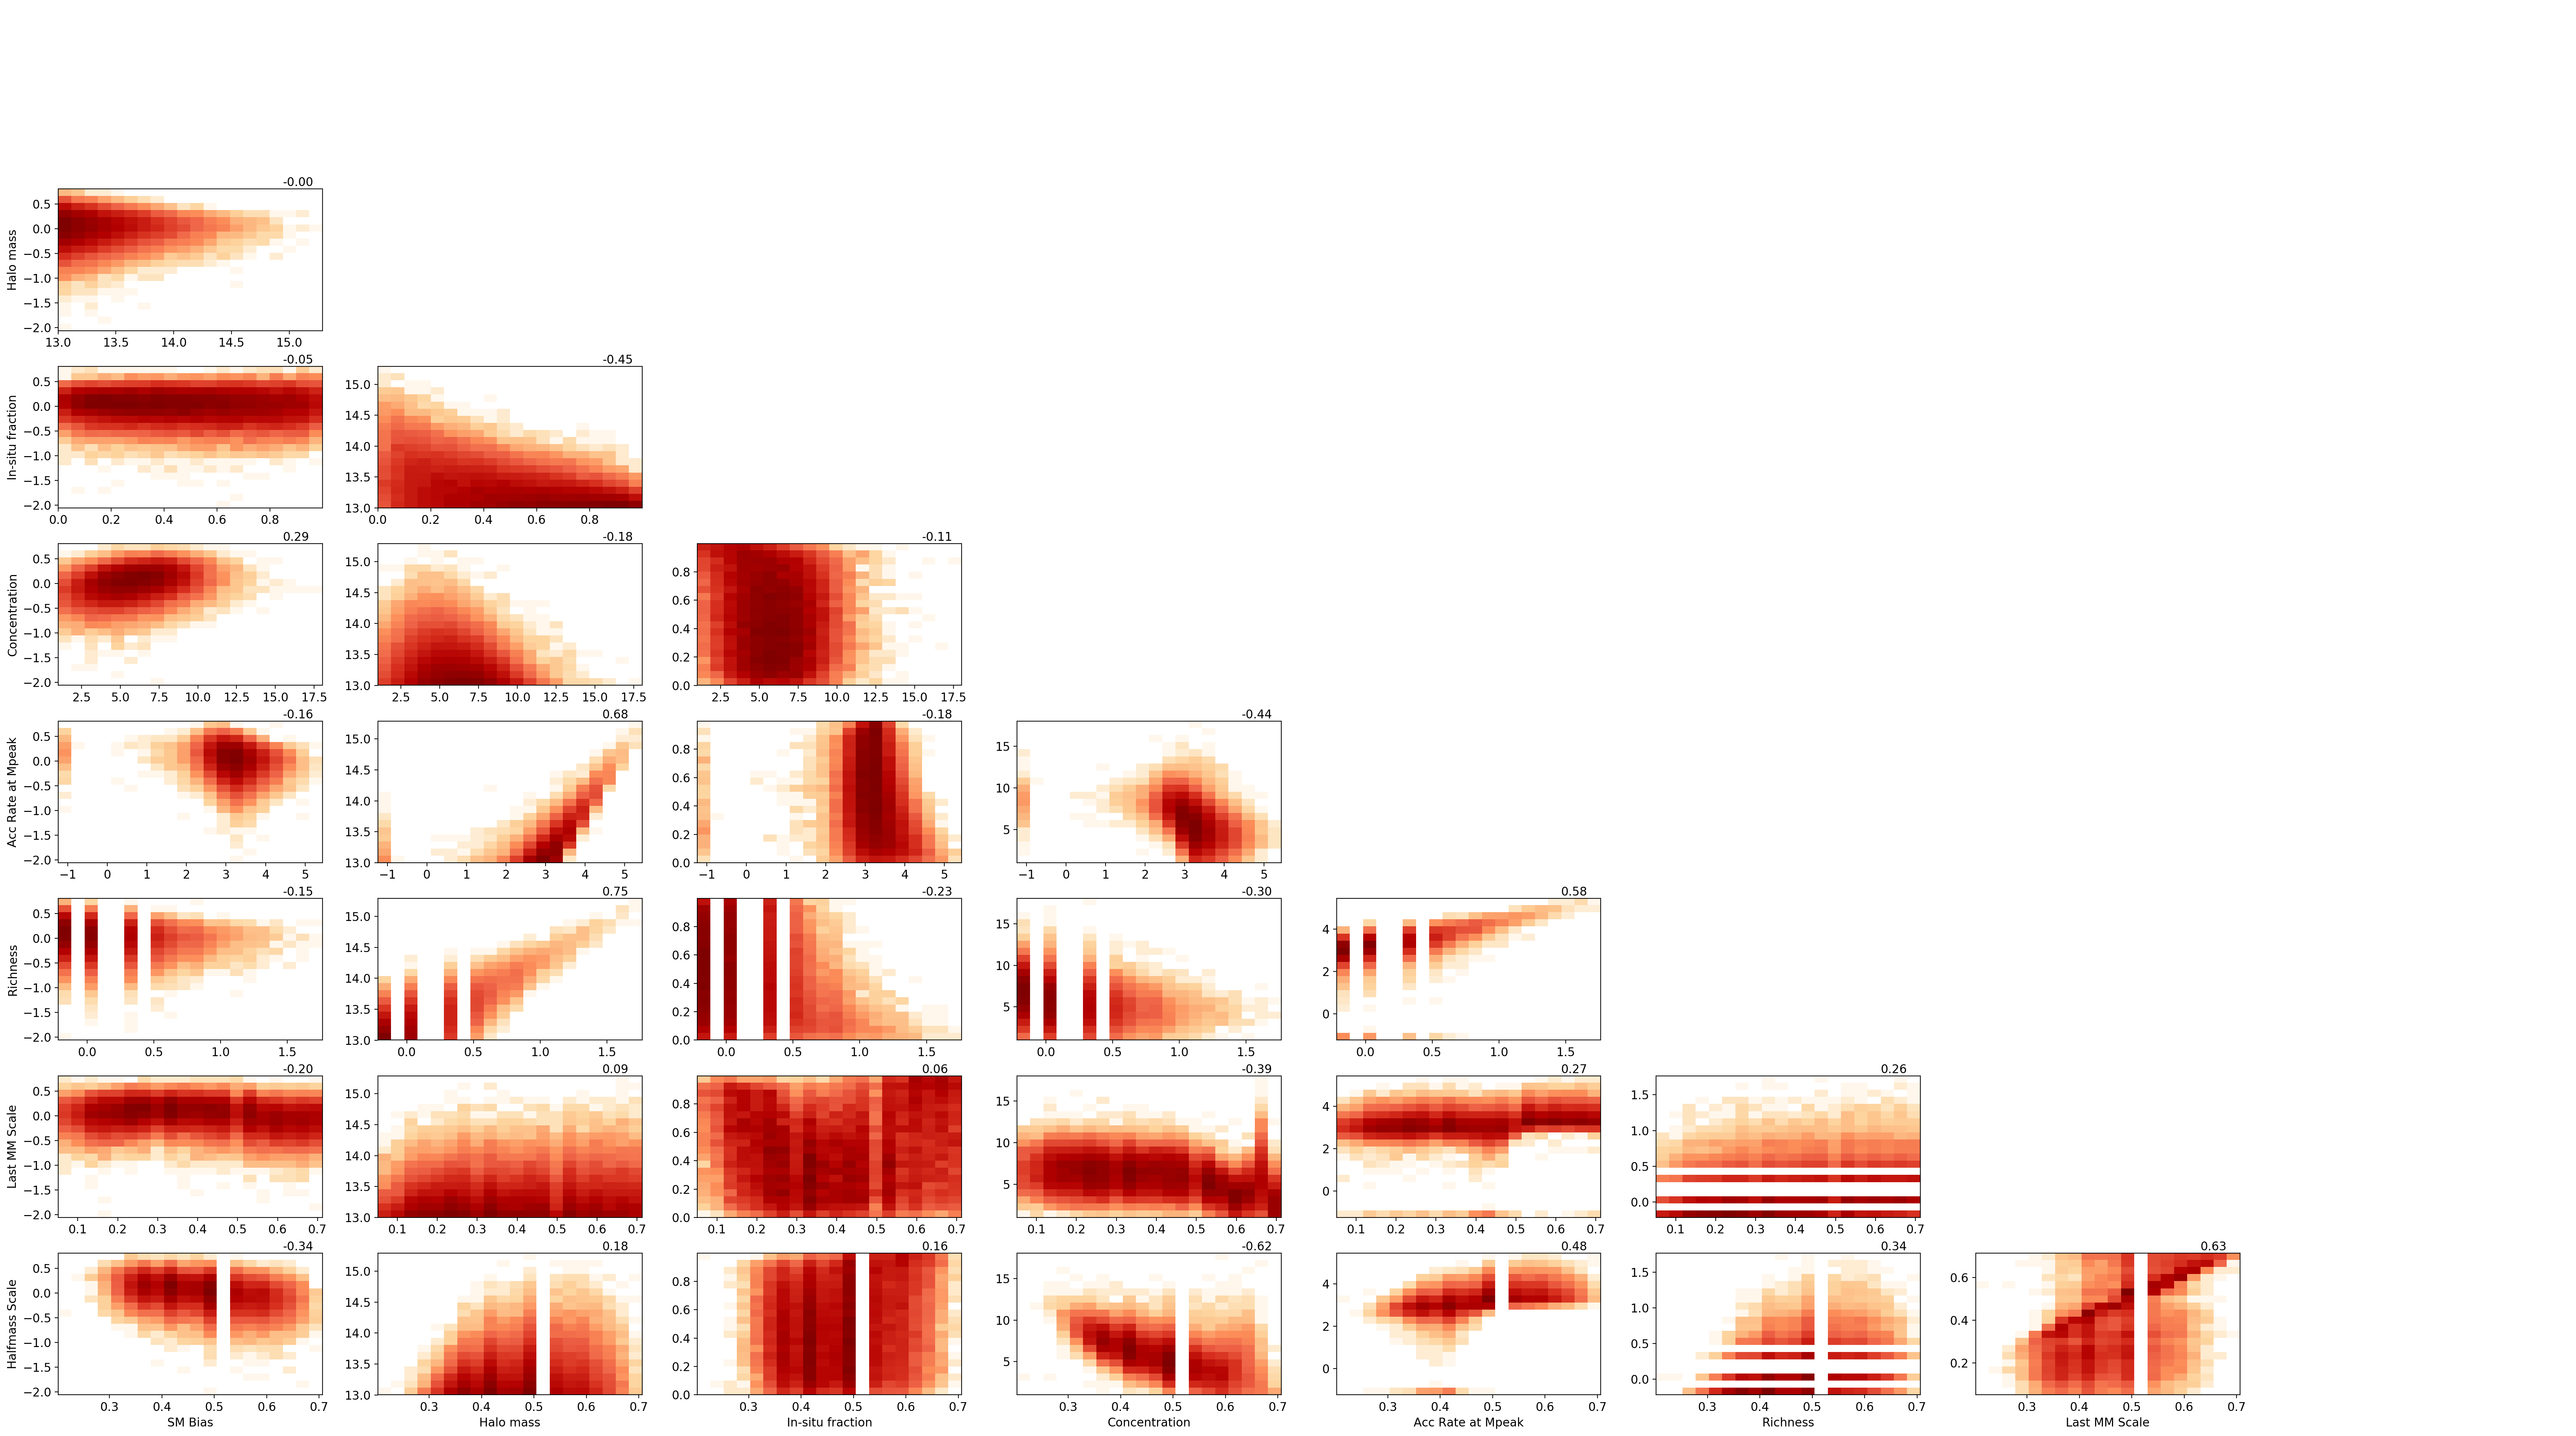

In [299]:
p.physical_correlation_plots.correlation_matrix(data_halo_cut["cen"])
p.physical_correlation_plots.correlation_matrix(data_halo_cut["halo"])
p.physical_correlation_plots.cen_vs_halo_correlation_matrix(data_halo_cut["cen"], data_halo_cut["halo"])
p.physical_correlation_plots.marginalized_heatmap(data_halo_cut["cen"])

## Use best model to predict SM bias

Using log10(alpha) of -3.5
[0.2686521  0.25145234 0.09215359]


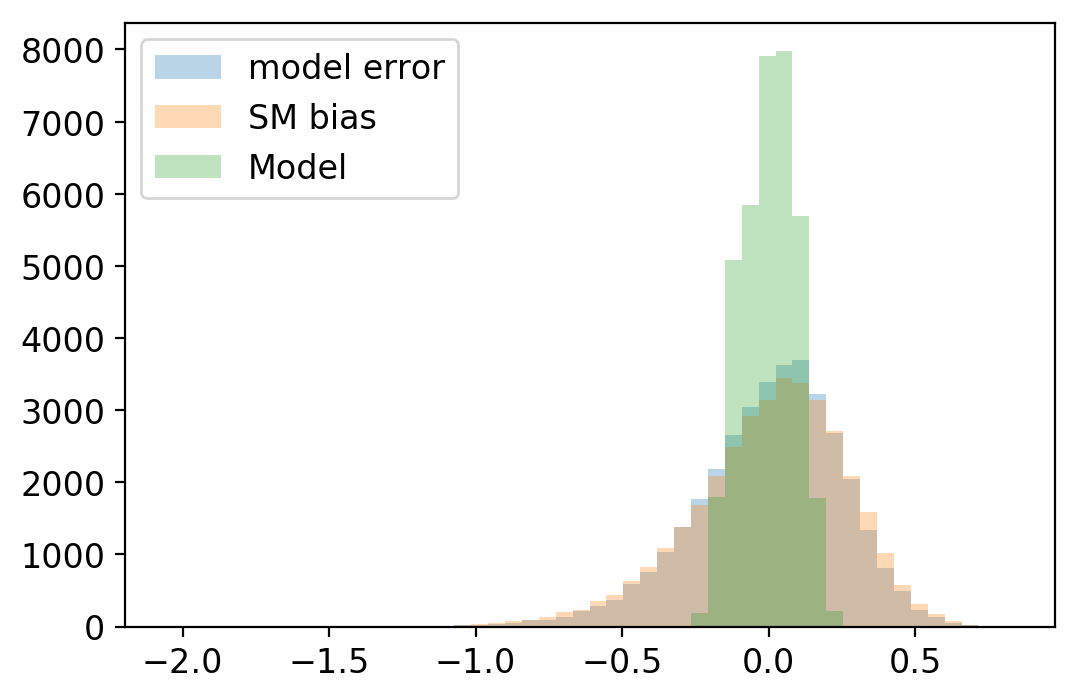

In [325]:
p.physical_correlation_plots.margin_model(data_halo_cut["cen"])

Using log10(alpha) of -3.5
[0.08868529 0.08436131 0.023891  ]


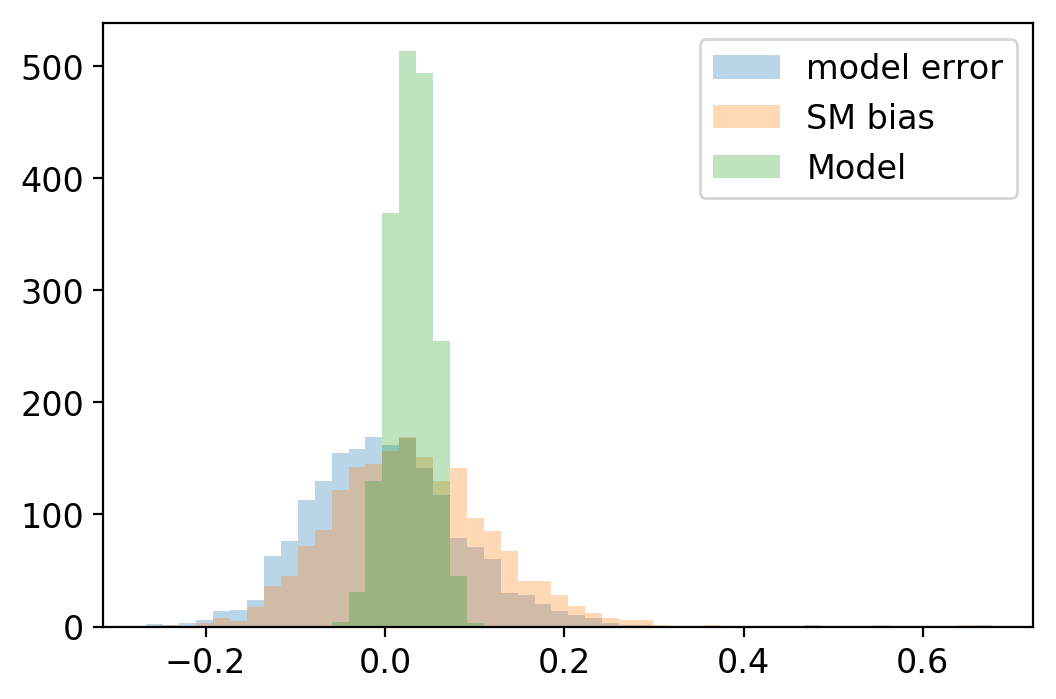

In [318]:
p.physical_correlation_plots.margin_model(data_halo_cut["halo"])


    This is the issue - even though when binned you see a nice trend,
    there is a massive amount of variance in each bin still. Increasing the number of
    features we build out linear model on doesn't appear to significantly improve this.
    Or maybe I haven't yet tried the right features.
    


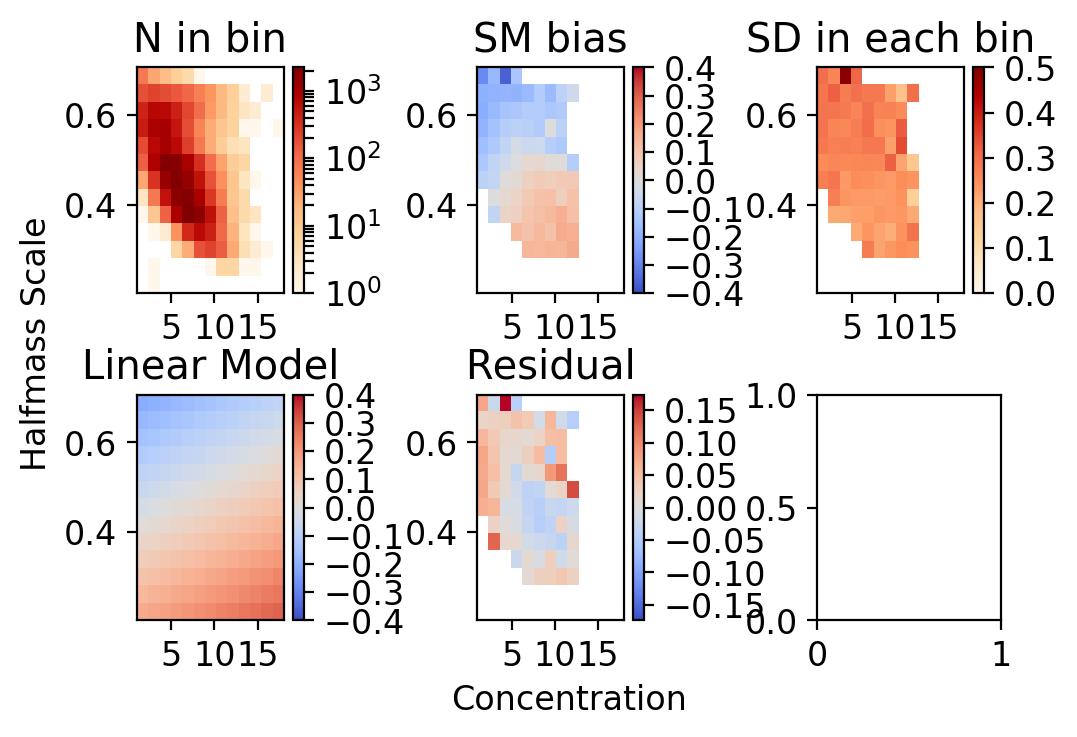

In [321]:
p.physical_correlation_plots.best_model(data_halo_cut["cen"])

# Concentration - is that correlated with over/undermassive halos

Same as richness but for concentration

[1.0, 3.0, 7.0, 19.0]


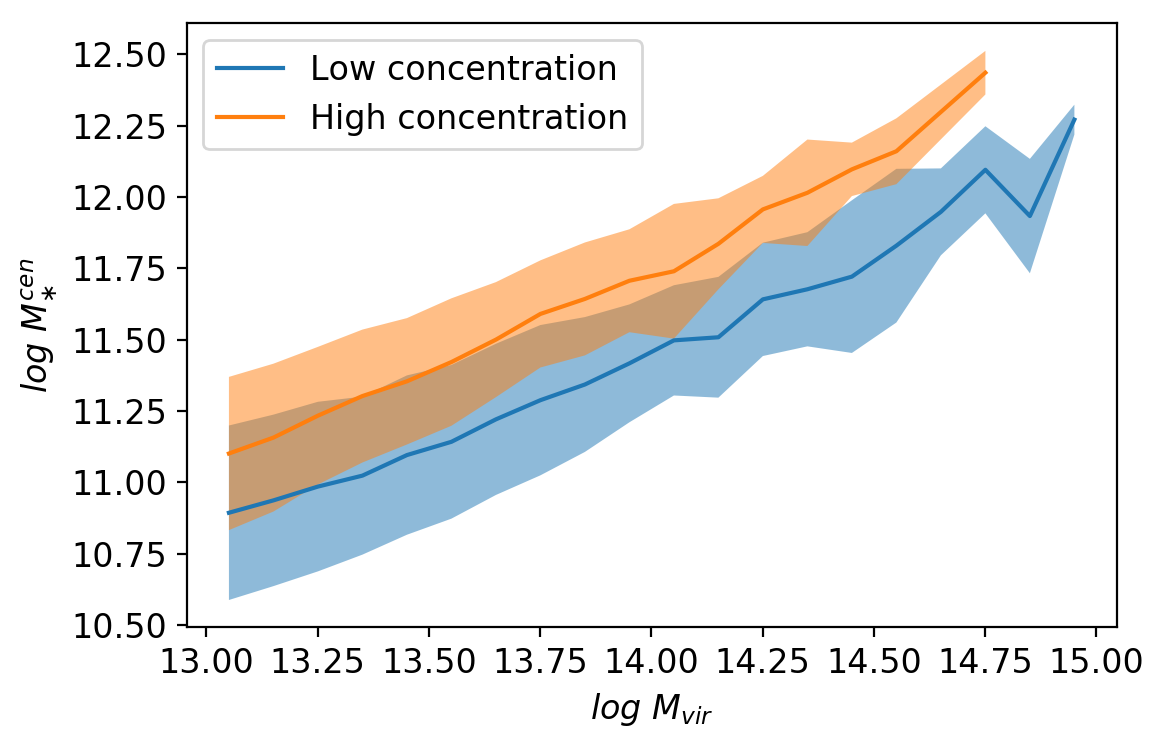

In [297]:
p.physical_correlation_plots.sm_at_fixed_hm_conc_split(data_halo_cut["cen"])

(2, 36491)
[[0.07217593 0.1604215 ]
 [0.1604215  4.37972125]]


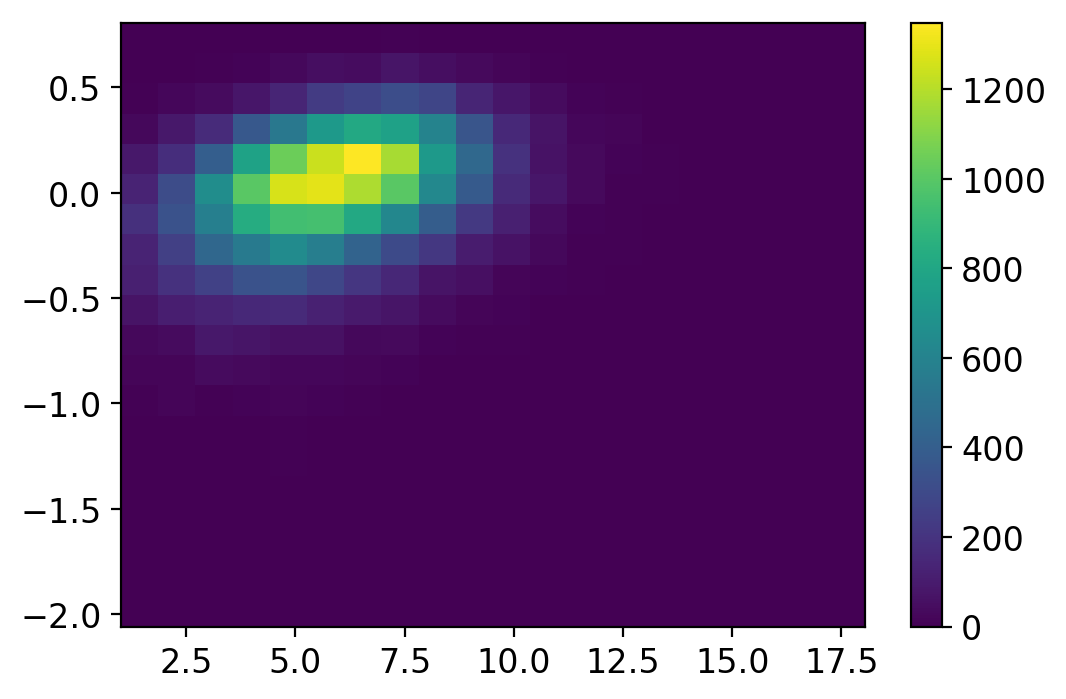

In [296]:
p.physical_correlation_plots.conc_sm_heatmap_at_fixed_hm(data_halo_cut["cen"])

# Age

What about age?

In [ ]:
p.physical_correlation_plots.sm_at_fixed_hm_age_split(data_halo_cut["halo"])

# Major Mergers

In [ ]:
p.physical_correlation_plots.sm_at_fixed_hm_mm_split(data_halo_cut["cen"])

# Comparison of secondary feature distribution

Let's look at how a selection on stellar mass could bias the secondary features.
1. Select a sample by cutting on some variant of SM
2. Select a sample by matching the halo mass distribution of 1
3. Compare features of 1 and 2

## Concentration

In [ ]:
cen_cuts = (11.9, 12.1)
halo_cuts = tuple(fits.mass_at_density(data_halo_cut, "halo", fits.density_at_mass(
        data_halo_cut, "cen", m)) for m in cen_cuts)
print("central cuts of {}, halo cuts of {}".format(cen_cuts, halo_cuts))

_, axes = plt.subplots(1, 2)
p.same_hm_dist_plots.plot_pdf(data_halo_cut, "cen", p.same_hm_dist_plots.f_concentration, cuts=cen_cuts, ax=axes[0], bins=18)
p.same_hm_dist_plots.plot_pdf(data_halo_cut, "halo", p.same_hm_dist_plots.f_concentration, cuts=halo_cuts, ax=axes[1], bins=18)
plt.tight_layout()
axes[1].set(**{"xlabel": "Concentration"})
for ax in [axes[0], axes[1]]:
    ax.set(**{"xlim": (min(axes[0].get_xlim()[0], axes[1].get_xlim()[0]), max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])), 
              "ylim": (0, max(axes[0].get_ylim()[1], axes[1].get_ylim()[1]))})

SM sample size: 509	SM median halo mass: 2.12e+14	SM std halo mass: 5.41e+13
Ks_2sampResult(statistic=0.031434184675834975, pvalue=0.9603450095109024)


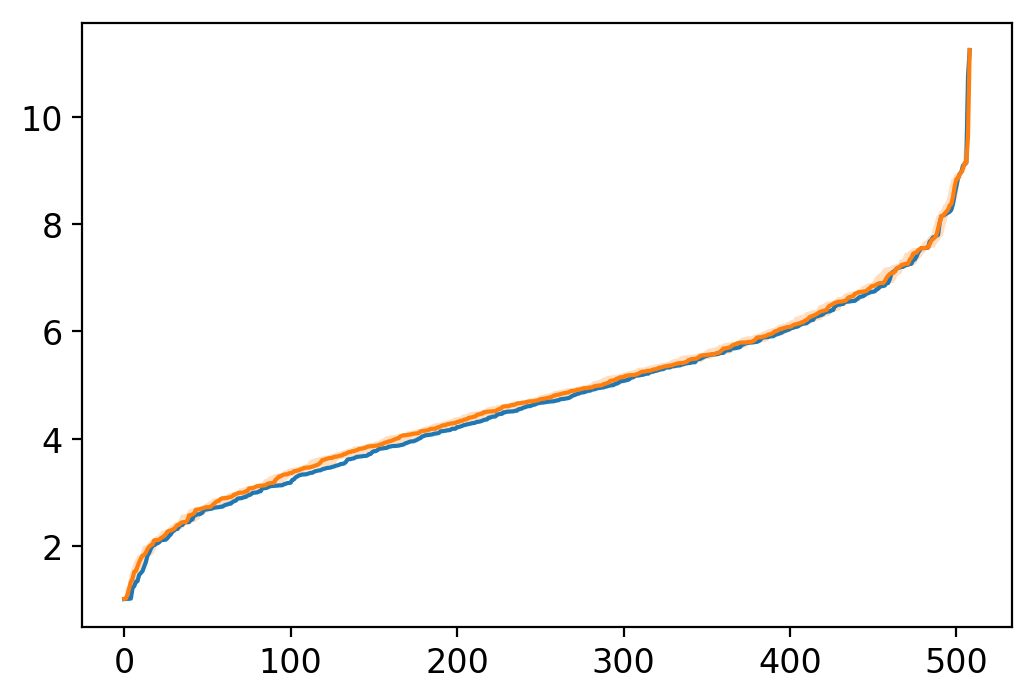

In [210]:
p.same_hm_dist_plots.plot_cdf(data_halo_cut, "halo", p.same_hm_dist_plots.f_concentration, cuts=halo_cuts)

## KS test

In [91]:
p.same_hm_dist_plots.compute_acc_gammas(data_halo_cut["cen"]["data"])

array([1.22440716, 0.15485091])

In [97]:
res = []
keys = ['cen', 1, 2, 5, 'halo']
labels = ["Concentration", "Halfmass Scale", "Last MM Scale", "Accretion Rate"]
cuts = [(11.6, 11.7), (11.9, 12.1)]

for cut in cuts:
    res.append([])
    for f_name in ["f_concentration","f_age", "f_mm", "f_acc"]:
        res[-1].append([])
        for k in keys:
            c = tuple(fits.mass_at_density(data_halo_cut, k, fits.density_at_mass(
                data_halo_cut, "cen", m)) for m in cut)
            res[-1][-1].append(p.same_hm_dist_plots.ks_test(data_halo_cut, k, getattr(p.same_hm_dist_plots, f_name), cuts=c))

SM sample size: 1794	SM median halo mass: 4.58e+13	SM std halo mass: 4.30e+13
SM sample size: 1783	SM median halo mass: 5.58e+13	SM std halo mass: 3.55e+13
SM sample size: 1815	SM median halo mass: 5.92e+13	SM std halo mass: 3.25e+13
SM sample size: 1791	SM median halo mass: 6.32e+13	SM std halo mass: 2.60e+13
SM sample size: 1788	SM median halo mass: 6.50e+13	SM std halo mass: 1.92e+13
SM sample size: 1794	SM median halo mass: 4.58e+13	SM std halo mass: 4.30e+13
SM sample size: 1783	SM median halo mass: 5.58e+13	SM std halo mass: 3.55e+13
SM sample size: 1815	SM median halo mass: 5.92e+13	SM std halo mass: 3.25e+13
SM sample size: 1791	SM median halo mass: 6.32e+13	SM std halo mass: 2.60e+13
SM sample size: 1788	SM median halo mass: 6.50e+13	SM std halo mass: 1.92e+13
SM sample size: 1794	SM median halo mass: 4.58e+13	SM std halo mass: 4.30e+13
SM sample size: 1783	SM median halo mass: 5.58e+13	SM std halo mass: 3.55e+13
SM sample size: 1815	SM median halo mass: 5.92e+13	SM std halo m

/home/christopher/research/hsc_um2/cb/plots/same_hm_dist_plots.py:142: RuntimeWarning: invalid value encountered in log10
  
/home/christopher/.virtualenvs/hsc_um2/lib/python3.6/site-packages/numpy/lib/function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


SM sample size: 1783	SM median halo mass: 5.58e+13	SM std halo mass: 3.55e+13
SM sample size: 1815	SM median halo mass: 5.92e+13	SM std halo mass: 3.25e+13
SM sample size: 1791	SM median halo mass: 6.32e+13	SM std halo mass: 2.60e+13
SM sample size: 1788	SM median halo mass: 6.50e+13	SM std halo mass: 1.92e+13
SM sample size: 513	SM median halo mass: 1.67e+14	SM std halo mass: 1.15e+14
SM sample size: 517	SM median halo mass: 1.84e+14	SM std halo mass: 1.08e+14
SM sample size: 519	SM median halo mass: 1.93e+14	SM std halo mass: 1.03e+14
SM sample size: 520	SM median halo mass: 2.02e+14	SM std halo mass: 7.31e+13
SM sample size: 509	SM median halo mass: 2.12e+14	SM std halo mass: 5.41e+13
SM sample size: 513	SM median halo mass: 1.67e+14	SM std halo mass: 1.15e+14
SM sample size: 517	SM median halo mass: 1.84e+14	SM std halo mass: 1.08e+14
SM sample size: 519	SM median halo mass: 1.93e+14	SM std halo mass: 1.03e+14
SM sample size: 520	SM median halo mass: 2.02e+14	SM std halo mass: 7.31

[1.1319284208938931e-12, 5.100442915293046e-19, 5.291415968902929e-13, 2.370661237400576e-08, 8.45191811239151e-12, 5.0313671762319476e-08]
[0.7303528641443393, 0.9349641485609963, 0.0838287096368459, 0.9603450095109024, 0.9603450095109016, 0.7195291940040611]


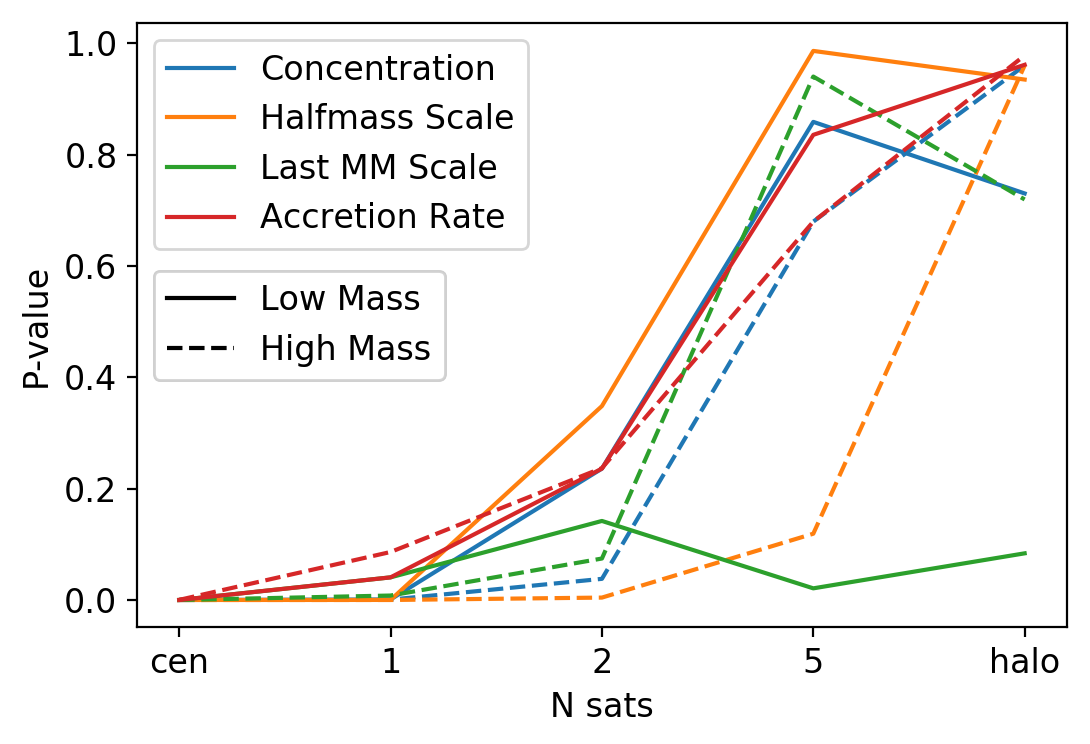

In [98]:
_, ax = plt.subplots()
lines = []
print([res[i][j][0] for i in range(2) for j in range(3)])
print([res[i][j][-1] for i in range(2) for j in range(3)])


for i in range(len(res[0])):
    l = ax.plot(res[0][i], label=labels[i])[0]
    lines.append(l)

    l2 = ax.plot(res[1][i], ls="dashed", color=l.get_color())[0]
    lines.append(l2)

ax.set(
    xticks=ax.get_xticks()[1::2],
    xticklabels=keys,
    ylabel="P-value",
    xlabel="N sats",
)

leg = ax.legend()
ax.add_artist(leg)

leg = ax.legend(handles=[lines[0], lines[1]], labels=["Low Mass", "High Mass"], loc="center left")
for i in range(len(leg.legendHandles)): leg.legendHandles[i].set_color("black")
ax.add_artist(leg)

## Age

SM sample size: 500	SM median halo mass: 1.67e+14	SM std halo mass: 1.16e+14
SM sample size: 509	SM median halo mass: 2.12e+14	SM std halo mass: 5.41e+13


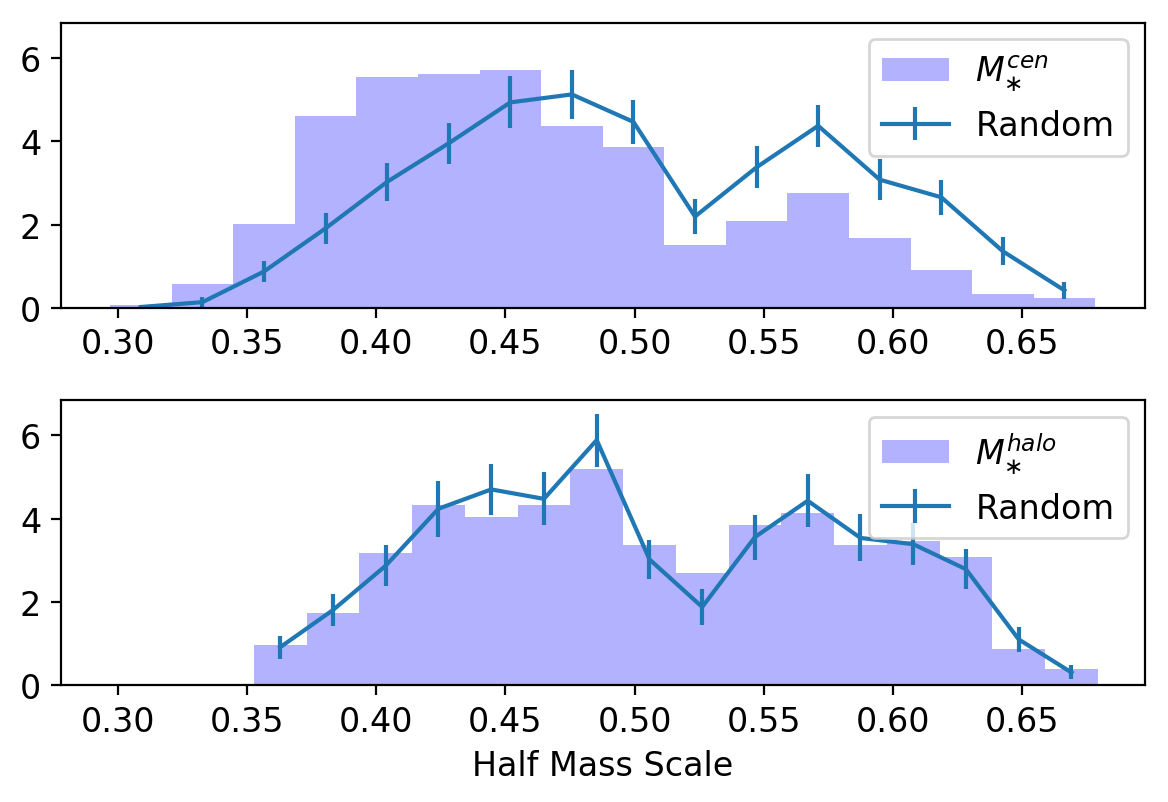

In [216]:
# Remember that the way we are binning this is a bit subtle
_, axes = plt.subplots(2, 1)
p.same_hm_dist_plots.plot_pdf(data_halo_cut, "cen", p.same_hm_dist_plots.f_age, cuts=cen_cuts, ax=axes[0], bins=16)
p.same_hm_dist_plots.plot_pdf(data_halo_cut, "halo", p.same_hm_dist_plots.f_age, cuts=halo_cuts, ax=axes[1], bins=16)
plt.tight_layout()
axes[1].set(**{"xlabel": "Half Mass Scale"})
for ax in [axes[0], axes[1]]:
    ax.set(**{"xlim": (min(axes[0].get_xlim()[0], axes[1].get_xlim()[0]), max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])), 
              "ylim": (0, max(axes[0].get_ylim()[1], axes[1].get_ylim()[1]))})

SM sample size: 509	SM median halo mass: 2.12e+14	SM std halo mass: 5.41e+13
Ks_2sampResult(statistic=0.03339882121807469, pvalue=0.935221521170702)


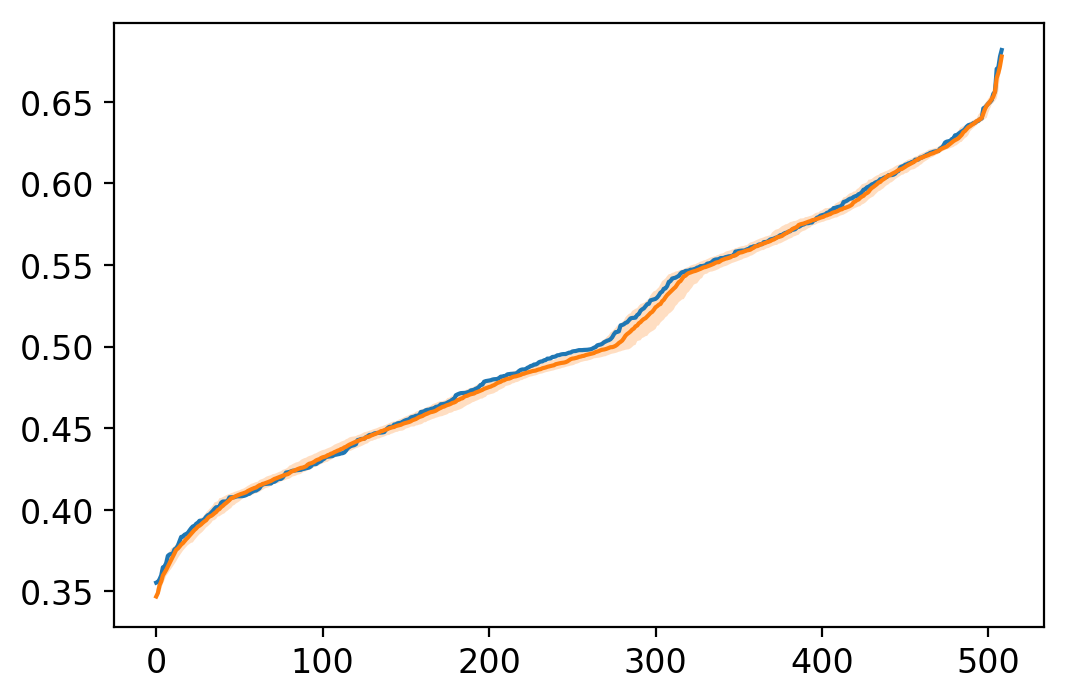

In [219]:
p.same_hm_dist_plots.plot_cdf(data_halo_cut, "halo", p.same_hm_dist_plots.f_age, cuts=halo_cuts)

## MM

SM sample size: 500	SM median halo mass: 1.67e+14	SM std halo mass: 1.16e+14
SM sample size: 509	SM median halo mass: 2.12e+14	SM std halo mass: 5.41e+13


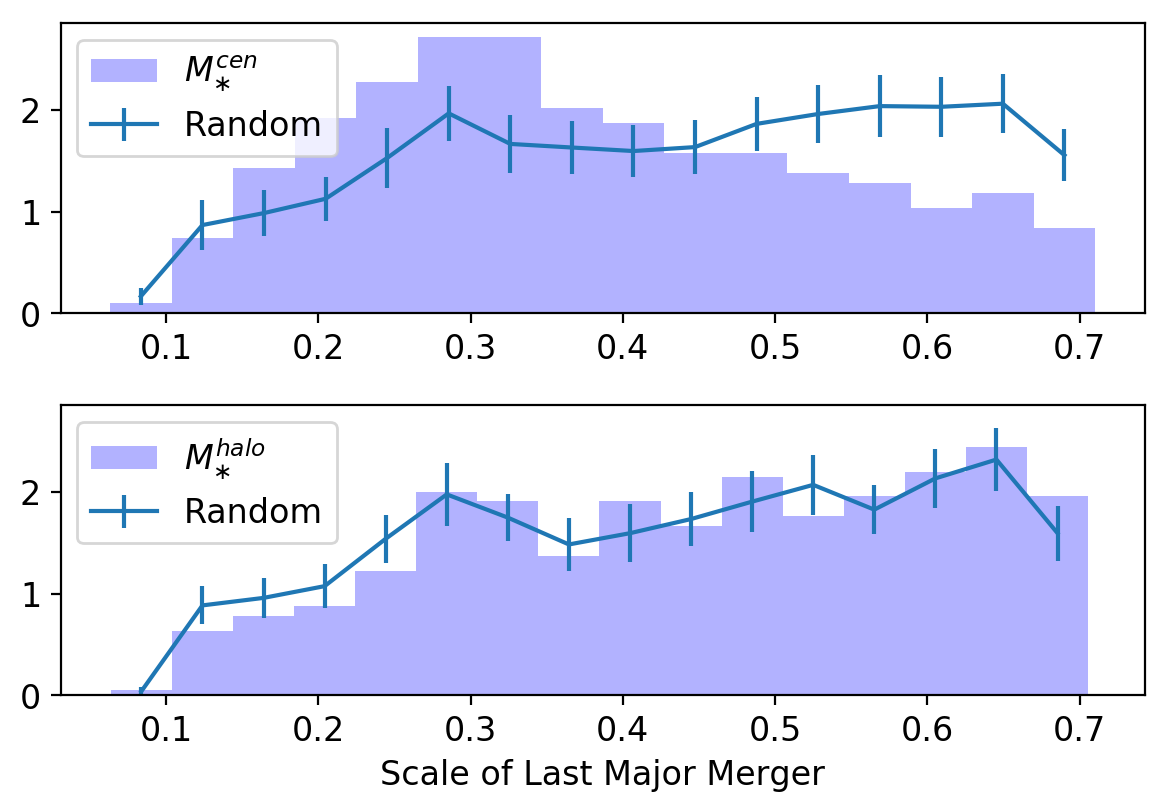

In [277]:
# Remember that the way we are binning this is a bit subtle
_, axes = plt.subplots(2, 1)
p.same_hm_dist_plots.plot_pdf(data_halo_cut, "cen", p.same_hm_dist_plots.f_mm, cuts=cen_cuts, ax=axes[0], bins=16)
p.same_hm_dist_plots.plot_pdf(data_halo_cut, "halo", p.same_hm_dist_plots.f_mm, cuts=halo_cuts, ax=axes[1], bins=16)
plt.tight_layout()
axes[1].set(**{"xlabel": "Scale of Last Major Merger"})
for ax in [axes[0], axes[1]]:
    ax.set(**{"xlim": (min(axes[0].get_xlim()[0], axes[1].get_xlim()[0]), max(axes[0].get_xlim()[1], axes[1].get_xlim()[1])), 
              "ylim": (0, max(axes[0].get_ylim()[1], axes[1].get_ylim()[1]))})

SM sample size: 509	SM median halo mass: 2.12e+14	SM std halo mass: 5.41e+13
Ks_2sampResult(statistic=0.04715127701375246, pvalue=0.6133971738415919)


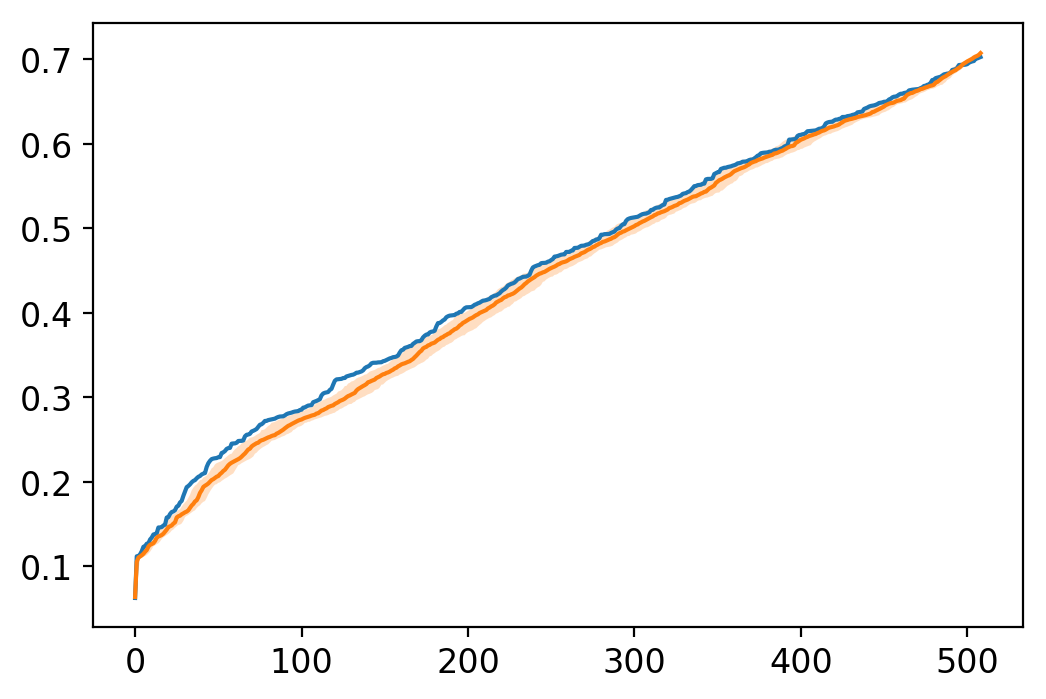

In [278]:
p.same_hm_dist_plots.plot_cdf(data_halo_cut, "halo", p.same_hm_dist_plots.f_mm, cuts=halo_cuts)

## Sanity check of how we bin discrete scales

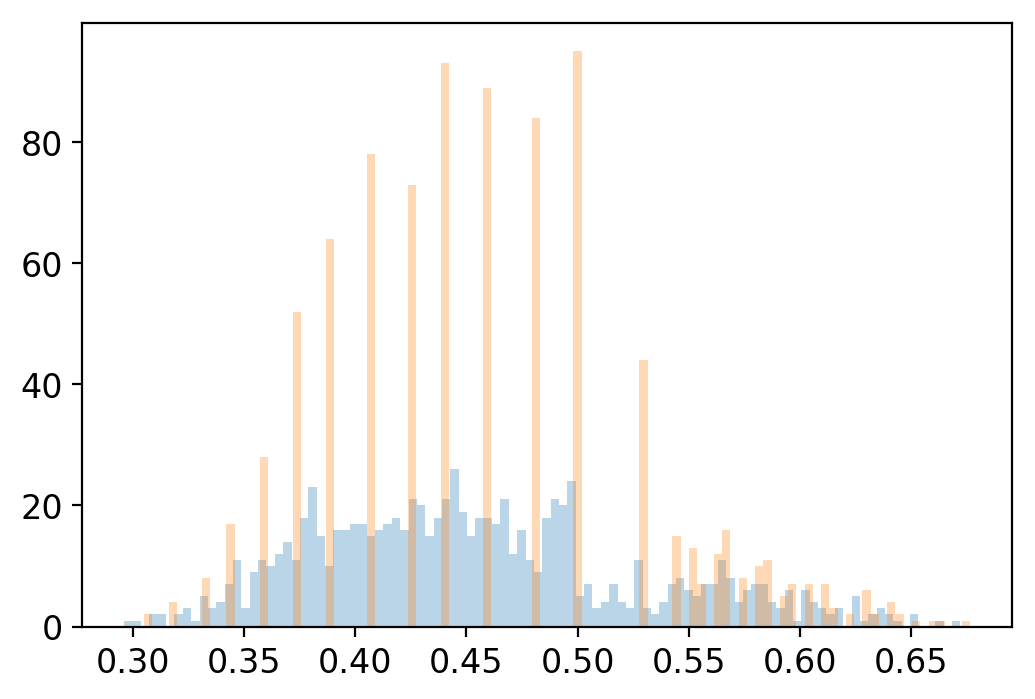

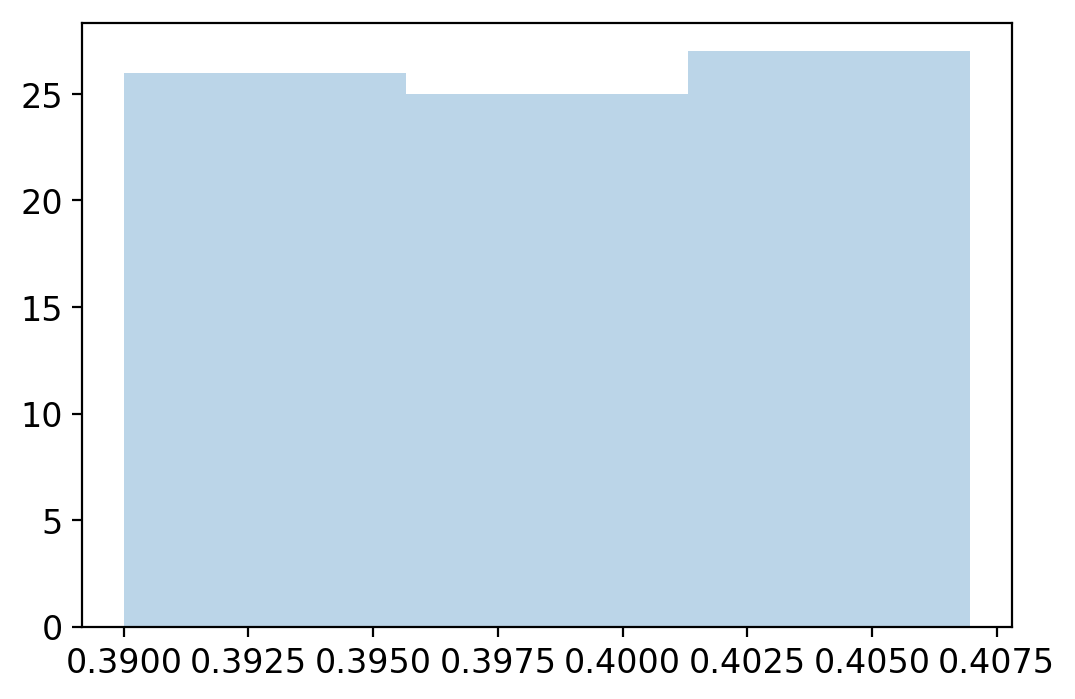

In [230]:
cuts = (11.8, 12)
catalog = data_halo_cut["cen"]["data"]
sm_sample = catalog[
    (catalog["sm"] + catalog["icl"] > 10**cuts[0]) & 
    (catalog["sm"] + catalog["icl"] < 10**cuts[1])   
]                   

p.same_hm_dist_plots.f_age(sm_sample, plot=True)
None

# Arb

## Alexies requests

See discussion in the Enia/Alexie/Me channel around Apr 24

In [184]:
def imshow(ax, binned_stats, **kwargs):
    return ax.imshow(
            binned_stats.statistic.T,
            origin="lower",
            extent=[binned_stats.x_edge[0], binned_stats.x_edge[-1], binned_stats.y_edge[0], binned_stats.y_edge[-1]],
            aspect="auto",
            **kwargs,
    )

In [239]:
# when the Gamma's are properly normalized, can you make a figure of how the mass gap (M*_central - M*_second most massive) correlates with accretion rate?
sample = data_stellar_cut["cen"]["data"]
gammas = p.same_hm_dist_plots.f_acc(sample)
mag_gap = data_stellar_cut["cen"]["mag_gap"]

indexes = (~np.isnan(gammas)) & (mag_gap > 0) #& (gammas > 0) & (gammas < 5)
gammas = gammas[indexes]
mag_gap = mag_gap[indexes]
masses = sample["sm"][indexes] + sample["icl"][indexes]

# Joined stuff
joined_sample = data.unify(data_stellar_cut, "cen", "halo")
joined_sample = joined_sample.rename(columns = {
    "m_cen": "m",
    "Acc_Rate_1*Tdyn_cen": "Acc_Rate_1*Tdyn",
}) # Need to do this for the f_acc func to find the cols
j_gammas = p.same_hm_dist_plots.f_acc(joined_sample)


j_halo_mass = joined_sample["sm_halo"] + joined_sample["icl_halo"]
j_cen_mass = joined_sample["sm_cen"] + joined_sample["icl_cen"]

indexes = (~np.isnan(j_gammas))
print(np.count_nonzero(indexes) / len(indexes))
j_gammas = j_gammas[indexes]
j_halo_mass = j_halo_mass[indexes]
j_cen_mass = j_cen_mass[indexes]
joined_sample = joined_sample[indexes]

Some here are less than 0
Some here are less than 0
0.9990766777185546


/home/christopher/research/hsc_um2/cb/plots/same_hm_dist_plots.py:144: RuntimeWarning: invalid value encountered in log10
  return sample["Acc_Rate_1*Tdyn"]


In [240]:
joined_sample[(np.log10(j_halo_mass) > 12.5) & (np.log10(j_cen_mass) < 11.3)].head() # These are weird fuckers

,id_cen,upid_cen,x_cen,y_cen,z_cen,m,mp_cen,sm_cen,icl_cen,sfr_cen,...,Halfmass_Scale_halo,scale_of_last_MM_halo,M200b_halo,M200c_halo,Acc_Rate_Inst_halo,Acc_Rate_100Myr_halo,Acc_Rate_1*Tdyn_halo,Acc_Rate_2*Tdyn_halo,Acc_Rate_Mpeak_halo,Vmax@Mpeak_halo
8324126763,8324126763,-1,223.820068,135.517746,294.313965,3.915000e+14,3.915000e+14,3.042000e+10,1.451000e+11,0.16310,...,0.6704,0.7124,2.981800e+14,1.942700e+14,384700.0,380700.0,108300.0,76650.0,65990.0,1050.53
8359247626,8359247626,-1,388.299591,297.560394,342.813538,2.469000e+14,2.488000e+14,1.233000e+10,1.581000e+11,0.04815,...,0.5623,0.6104,1.781200e+14,1.448600e+14,4085.0,3787.0,23070.0,43450.0,39770.0,947.02


Invalidating < 5
Invalidating < 5


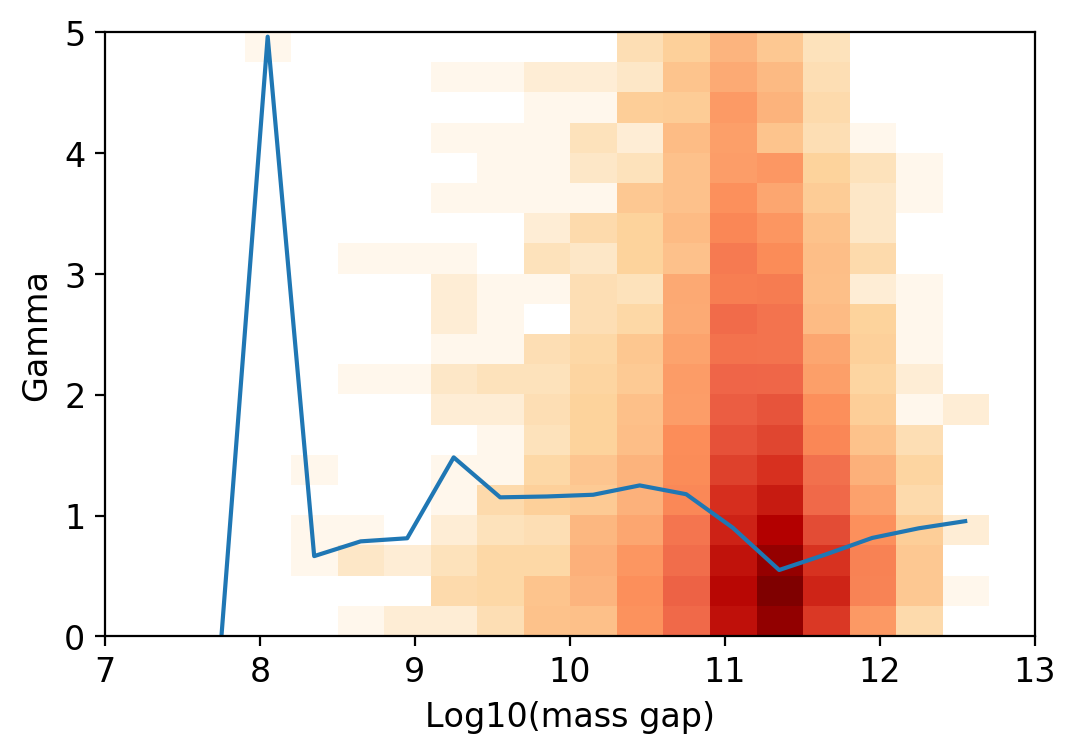

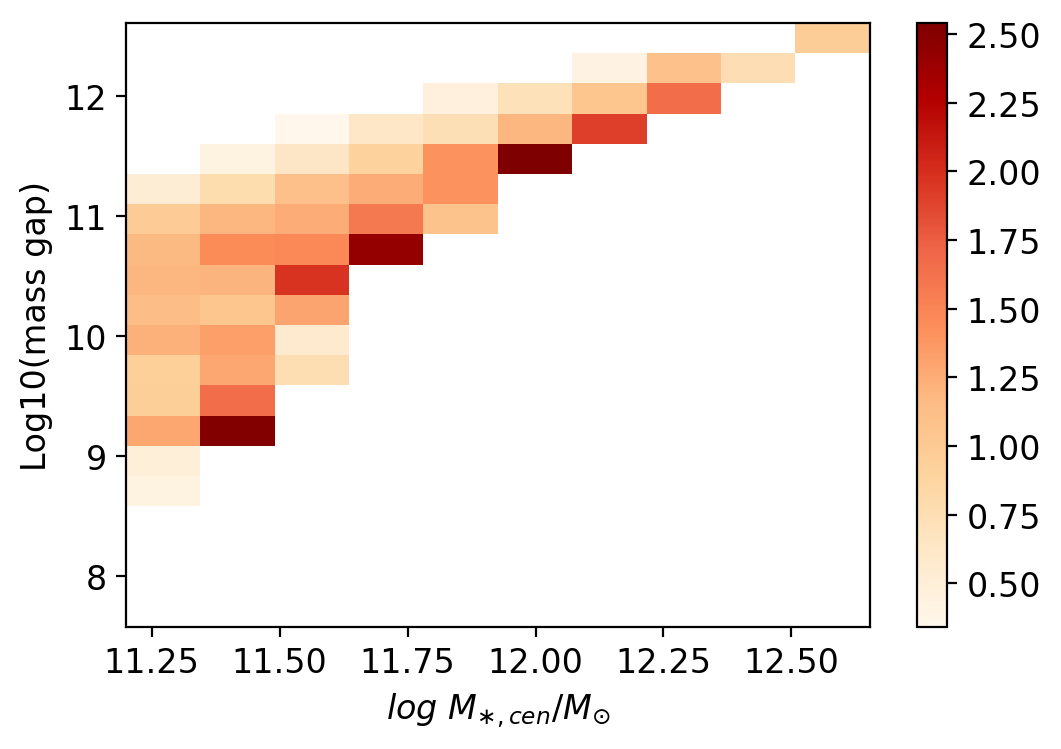

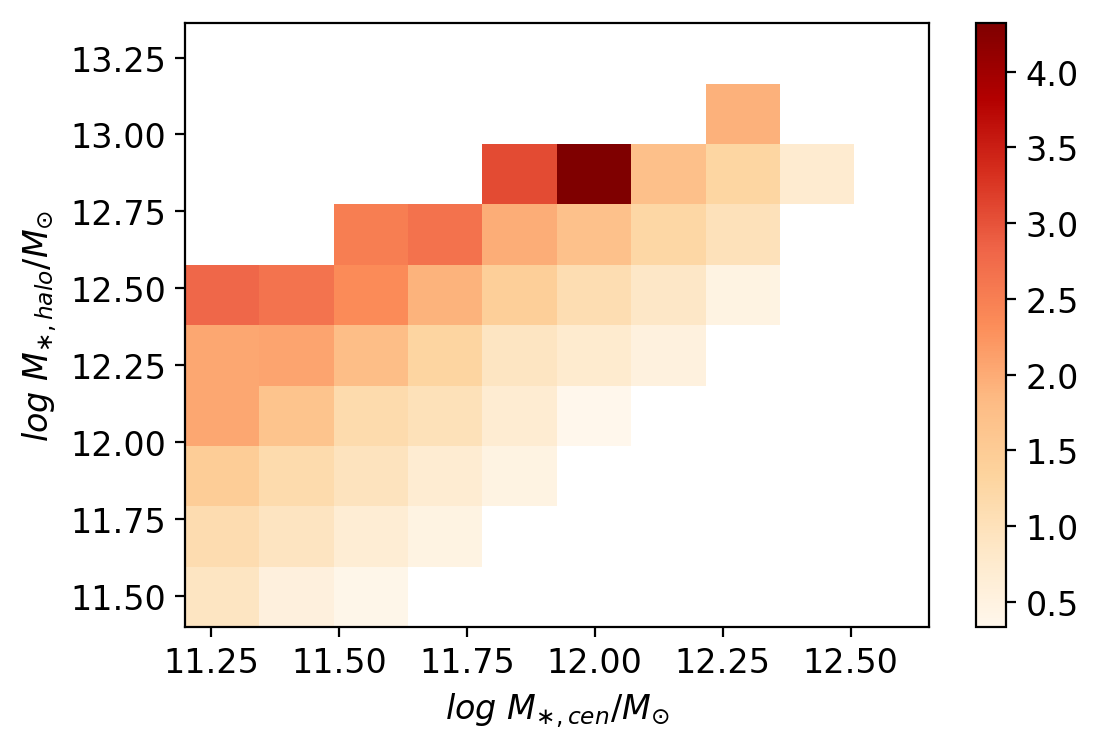

In [234]:
#### 1
p.gamma.one(mag_gap, gammas)


p.gamma.two(masses, mag_gap, gammas)
p.gamma.three(j_cen_mass, j_halo_mass, j_gammas)

## Weird systems

These systems are weird

2389
SM + ICL masses
11.244326610230637
11.511656132123303
12.642821071966178
SM masses
10.48315920971698
11.310268366632448
Halo masses
14.592731766393962
14.258397804095509


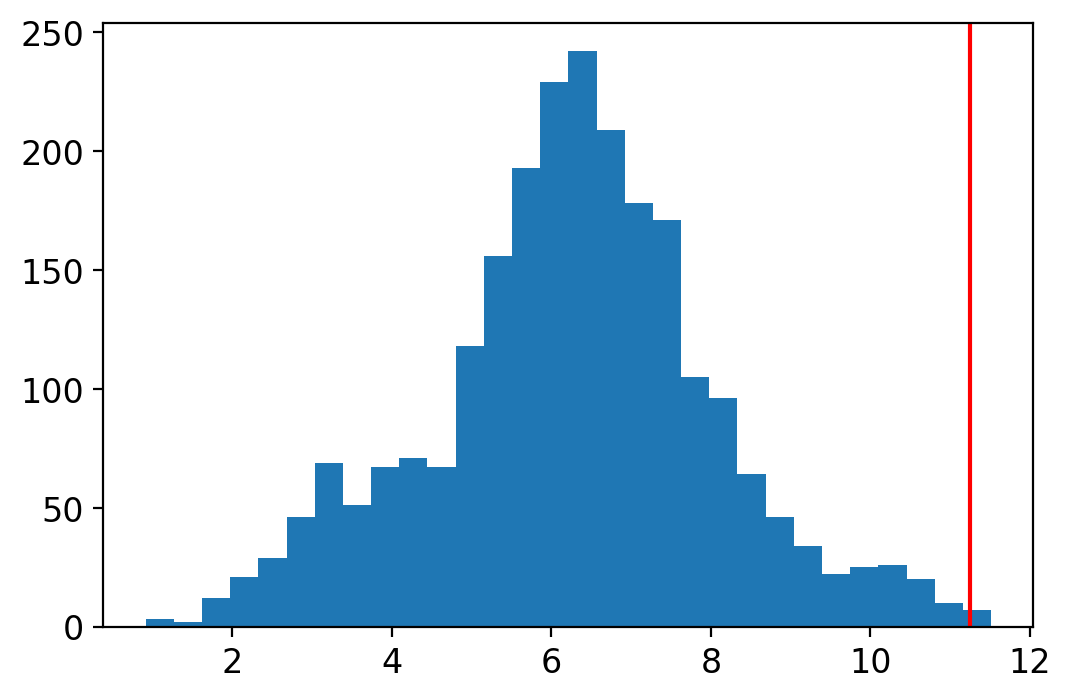

In [262]:
ids = [8324126763, 8359247626] # in the stellar cut, these have low central stellar masses but significantly higher halo stellar masses
x = 8324126763

cent = centrals[centrals["id"] == x][0]
sats = satellites[satellites["upid"] == x]
print(len(sats))

sat_masses = sats["sm"] + sats["icl"]
cent_mass = cent["sm"] + cent["icl"]
_, ax = plt.subplots()
ax.hist(np.log10(sat_masses), bins=30)
ax.axvline(np.log10(cent_mass), color="r")

print("SM + ICL masses")
print(np.log10(cent_mass))
print(np.log10(np.max(sat_masses)))
print(np.log10(cent_mass + np.sum(sat_masses)))

print("SM masses")
print(np.log10(cent["sm"]))
print(np.log10(np.max(sats["sm"])))

print("Halo masses")
print(np.log10(cent["m"]))
print(np.log10(np.max(sats["mp"])))